### Lab 3. Gradient descent methods


1. Implement:

   (a) Constant-step gradient descent;

   (b) Gradient descent with fractional steps (Armijo condition);

   (c) Steepest descent (using any two one-dimensional search methods);

   (d) Conjugate gradient method (with restart).

2. For the study, consider:

   (a) Well-conditioned (μ ≃1) two-dimensional quadratic function;

   (b) Ill-conditioned (μ > 10) two-dimensional quadratic function;

   (c) Rosenbrock function.

3. For each function:

   (a) Build a table that reflects the dependence of the number of iterations of the gradient method, the number of function calculations(if any), and the number of function gradient calculations (if any) for each of the methods on the chosen accuracy;

   (b) plot the data from the table (abscissa axis – accuracy, ordinate axis – number of iterations/function/gradient calculations);

4. For the Rosenbrock function, plot and compare the trajectories of each method on the level line plot.

5. Implement a generator of quadratic functions of a given dimension and condition number. Investigate the dependence of the number of iterations that must be performed to achieve the selected accuracy, depending on these parameters. Consider this dependence for two gradient methods, one of which is (necessarily) the conjugate gradient method.


#### 1

Implement:

(a) Constant-step gradient descent;

(b) Gradient descent with fractional steps (Armijo condition);

(c) Steepest descent (using any two one-dimensional search methods);

(d) Conjugate gradient method (with restart).


In [16]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown
from typing import Callable


In [17]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros_like(x, dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        # print(f(x + dx))
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f


In [18]:
# a
def gd_constant_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    eps: float = 1e-9,
    info=False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x) < eps:
            break

        trajectory.append(x.copy())
        iters += 1
        grad_calls += 1

        x -= lr * grad(f, x)

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x


In [19]:
# b
def gd_fractional_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    gamma: float = np.finfo(float).eps * 10,
    eps: float = np.finfo(float).eps * 10,
    lamb=0.5,
    info: bool = False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x) < eps:
            break

        iters += 1
        calls += 2
        grad_calls += 1
        trajectory.append(x.copy())

        g = grad(f, x)
        if f(x) - f(x - lr * g) > gamma * lr * np.linalg.norm(g) ** 2:
            x -= lr * g
        else:
            lr *= lamb
            x -= lr * g

    trajectory.append(x.copy())
    if info:
        return x.copy(), iters, calls, grad_calls, trajectory
    else:
        return x.copy()


In [20]:
def brent_search(f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False):
    iter_count, f_call_count = 1, 1
    if b < a:
        a, b = b, a
    K = (3 - 5**0.5) / 2
    x = w = v = (a + b) / 2
    fw = fv = fx = f(x)
    deltax = 0.0
    iter = 0
    maxiter = 1e9
    while iter < maxiter:
        iter += 1
        iter_count += 1

        mintol = eps / 4
        tol1 = eps * np.abs(x) + mintol
        tol2 = 2.0 * tol1
        xmid = 0.5 * (a + b)
        # check for convergence
        if np.abs(x - xmid) < (tol2 - 0.5 * (b - a)):
            break
        if np.abs(deltax) <= tol1:
            if x >= xmid:
                deltax = a - x  # do a golden section step
            else:
                deltax = b - x
            rat = K * deltax
        else:  # do a parabolic step
            tmp1 = (x - w) * (fx - fv)
            tmp2 = (x - v) * (fx - fw)
            p = (x - v) * tmp2 - (x - w) * tmp1
            tmp2 = 2.0 * (tmp2 - tmp1)
            if tmp2 > 0.0:
                p = -p
            tmp2 = np.abs(tmp2)
            dx_temp = deltax
            deltax = rat
            # determine whether a parabolic step is acceptable or not:
            if (
                (p > tmp2 * (a - x))
                and (p < tmp2 * (b - x))
                and (np.abs(p) < np.abs(0.5 * tmp2 * dx_temp))
            ):
                # whew, parabolic fit:
                rat = p * 1.0 / tmp2
                u = x + rat
                if (u - a) < tol2 or (b - u) < tol2:
                    if xmid - x >= 0:
                        rat = tol1
                    else:
                        rat = -tol1
            else:
                # nope, try golden section instead
                if x >= xmid:
                    deltax = a - x
                else:
                    deltax = b - x
                rat = K * deltax
        # update current position:
        if np.abs(rat) < tol1:  # update by at least tol1
            if rat >= 0:
                u = x + tol1
            else:
                u = x - tol1
        else:
            u = x + rat
        fu = f(u)
        f_call_count += 1
        if fu > fx:
            # Oh dear, point u is worse than what we have already,
            # even so it *must* be better than one of our endpoints:
            if u < x:
                a = u
            else:
                b = u

            if (fu <= fw) or (w == x):
                # however it is at least second best:
                v = w
                w = u
                fv = fw
                fw = fu
            elif (fu <= fv) or (v == x) or (v == w):
                # third best:
                v = u
                fv = fu
        else:
            # good new point is an improvement!
            # update brackets:
            if u >= x:
                a = x
            else:
                b = x
            # update control points:
            v = w
            w = x
            x = u
            fv = fw
            fw = fx
            fx = fu
    res = x
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [21]:
def golden_section_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False
):
    iter_count, f_call_count = 0, 0
    if b < a:
        a, b = b, a
    # golden ratio
    gr = (5**0.5 - 1) / 2

    iter_count += 1
    f_call_count += 2
    x = b - (b - a) * gr
    y = a + (b - a) * gr
    fx = f(x)
    fy = f(y)
    while b - a > eps:
        iter_count += 1
        f_call_count += 1
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * gr
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * gr
            fy = f(y)

    res = (b + a) / 2
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [22]:
# c
def steepest_descent(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float = 0.1,
    method: str = "golden_section",
    maxit: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x) < eps:
            break

        iters += 1
        grad_calls += 1
        trajectory.append(x.copy())

        g = grad(f, x)
        lr, iter_count, f_call_count, unsertainty = search_method(
            lambda y: f(x - y * g), 0, max_lr, eps=eps, info=True
        )
        calls += f_call_count

        x -= lr * g

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x


In [23]:
# d
def conjugate_gradient(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float = 0.1,
    method: str = "golden_section",
    max_it: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    max_subit: int = None,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if max_subit is None:
        max_subit = len(x0)
    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(max_it):
        if np.linalg.norm(x) < eps:
            break
        grad_calls += 1
        g = grad(f, x)
        r0 = -g
        d = r0
        for k in range(max_subit):
            if np.linalg.norm(x) < eps:
                break

            lr, iter_count, f_call_count, unsertainty = search_method(
                lambda y: f(x + y * d), 0, max_lr, eps=eps, info=True
            )
            iters += 1
            calls += f_call_count
            grad_calls += 1
            trajectory.append(x.copy())

            x += lr * d
            r1 = -grad(f, x)
            # Polak-Ribiere
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                beta = r1.T @ (r1 - r0) / (r0.T @ r0)
            if np.isnan(beta):
                beta = 0.0
            beta = max(beta, 0.0)
            d = r1 + beta * d
            r0 = r1

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x


In [24]:
def test_gd_simple():
    def f1(x):
        return np.linalg.norm(x) ** 2

    print(gd_constant_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_constant_step(f1, np.random.random(1), 0.1), 0)
    print(gd_fractional_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_fractional_step(f1, np.random.random(1), 0.1), 0)
    print(steepest_descent(f1, np.random.random(1), 0.1))
    assert np.isclose(steepest_descent(f1, np.random.random(1), 0.1), 0)
    print(conjugate_gradient(f1, np.random.random(1), 0.1))
    assert np.isclose(conjugate_gradient(f1, np.random.random(1), 0.1), 0)


test_gd_simple()


[9.97389449e-10]
[1.96180155e-15]
[1.97167306e-15]
[1.95772058e-15]


#### 2

For the study, consider:

(a) Well-conditioned (μ ≃1) two-dimensional quadratic function;

(b) Ill-conditioned (μ > 10) two-dimensional quadratic function;

(c) Rosenbrock function.


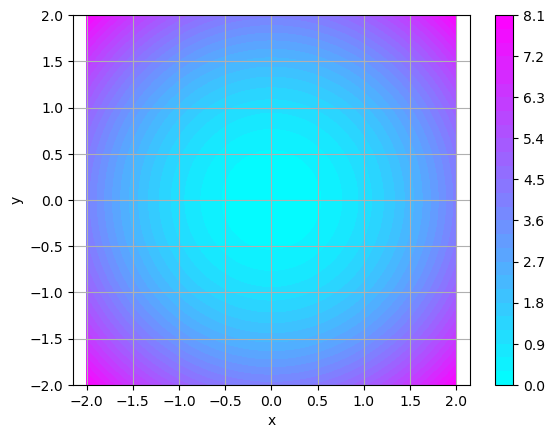

In [25]:
# a
@nb.njit
def f_a(x: np.ndarray) -> np.ndarray:
    assert len(x.shape) == 1
    assert x.shape[0] == 2
    mu = 1
    w = np.sqrt(mu)
    D = np.diag(np.array([1.0, 1.0]))
    C = np.array([[5.0, 3.0], [4.0, 2.0]])
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B) / 2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    assert np.isclose(np.linalg.cond(A), mu)
    return x.T @ A @ x


def test_f_a():
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    # cond_num = z.copy()
    # grad_norm = z.copy()
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_a(p)
            # cond_num[qy, qx] = np.linalg.norm(p)/np.linalg.norm(f_a(p))*np.linalg.norm(grad(f_a, p))
            # grad_norm[qy, qx] = np.linalg.norm(grad(f_a, p))

    plt.contourf(x, y, z, levels=30, cmap="cool")
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()
    # plt.contourf(x, y, cond_num, levels=30)
    # plt.grid()
    # plt.axis("equal")
    # plt.xlabel("x")
    # plt.ylabel("y")
    # plt.colorbar()
    # plt.show()

    # plt.contourf(x, y, grad_norm, levels=30)
    # plt.grid()
    # plt.axis("equal")
    # plt.xlabel("x")
    # plt.ylabel("y")
    # plt.colorbar()
    # plt.show()


test_f_a()


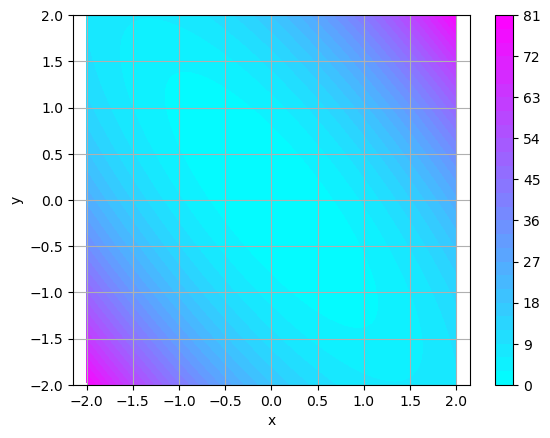

In [26]:
# b
@nb.njit
def f_b(x: np.ndarray) -> np.ndarray:
    assert len(x.shape) == 1
    assert x.shape[0] == 2

    mu = 10.0
    w = np.sqrt(mu)
    D = np.diag(np.array([w, 1.0]))
    C = np.array([[5.0, 3.0], [4.0, 2.0]])
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B) / 2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    assert np.isclose(np.linalg.cond(A), mu)
    return x.T @ A @ x


def test_f_b():
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_b(p)

    plt.contourf(x, y, z, levels=30, cmap="cool")
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()


test_f_b()


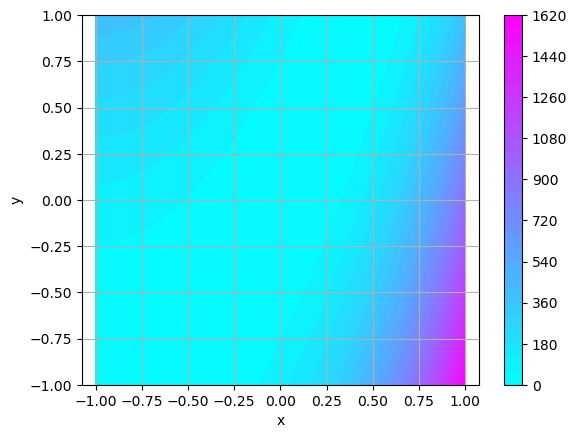

In [27]:
# c
@nb.njit
def f_c(x: np.ndarray) -> np.ndarray:
    # rosenbrock - shifted so that minimum at (0,0)
    # a:float=1.
    # b:float=100.
    # assert len(x.shape) == 1
    # assert x.shape[0] == 2
    # yp = x[1]+a**2
    # xp = x[0]+a
    # return (a - xp) ** 2 + b * (yp - xp ** 2) ** 2
    return (x[0]) ** 2 + 100.0 * ((x[1] + 1.0) - (x[0] + 1.0) ** 2) ** 2


def test_f_c():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_c(p)

    plt.contourf(x, y, z, levels=30, cmap="cool")
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()


test_f_c()


#### 3

For each function:

(a) Build a table that reflects the dependence of the number of iterations of the gradient method, the number of function calculations(if any), and the number of function gradient calculations (if any) for each of the methods on the chosen accuracy;

(b) plot the data from the table (abscissa axis – accuracy, ordinate axis – number of iterations/function/gradient calculations);


$\mu \approx 1$

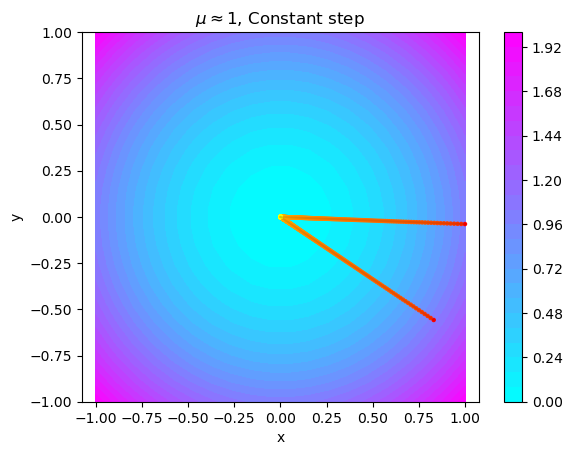

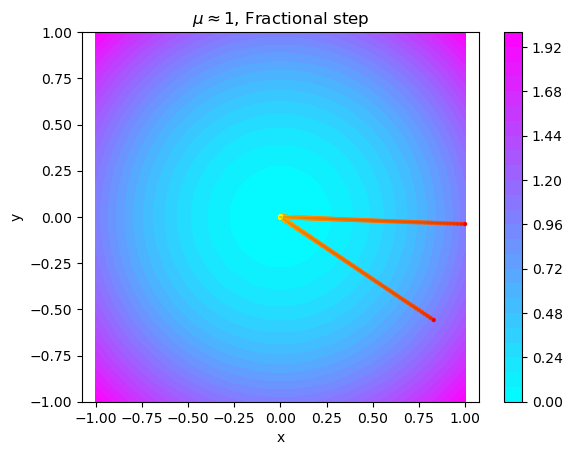

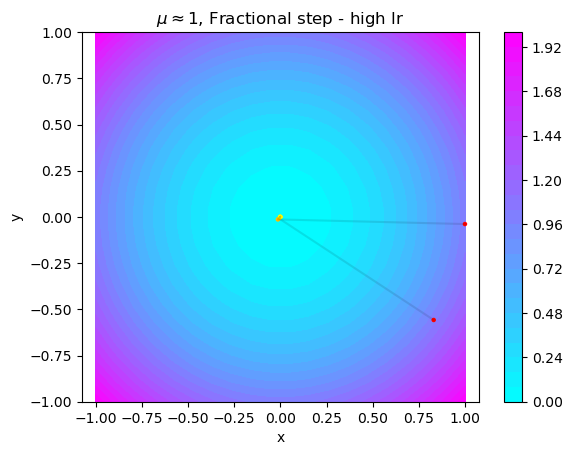

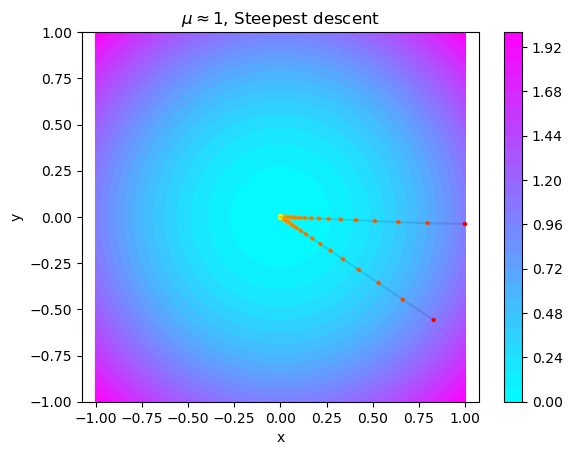

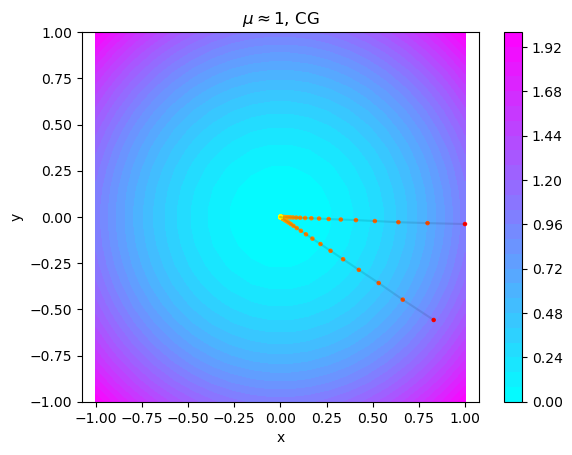

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              9.891858e-02                    114   
1   3.359818e-02              3.356405e-02                    168   
2   1.128838e-02              1.127429e-02                    222   
3   3.792690e-03              3.786993e-03                    276   
4   1.274275e-03              1.272040e-03                    330   
5   4.281332e-04              4.272762e-04                    384   
6   1.438450e-04              1.435215e-04                    438   
7   4.832930e-05              4.820865e-05                    492   
8   1.623777e-05              1.619321e-05                    546   
9   5.455595e-06              5.439277e-06                    600   
10  1.832981e-06              1.827045e-06                    654   
11  6.158482e-07              6.137017e-07                    708   
12  2.069138e-07              2.061415e-07                    762   
13  6.951928e-08              6.924262e-08                    816   
14  2.335721e-08              2.325849e-08                    870   
15  7.847600e-09              7.812494e-09                    924   
16  2.636651e-09              2.624205e-09                    978   
17  8.858668e-10              1.682563e-09                   1000   
18  2.976351e-10              1.682563e-09                   1000   
19  1.000000e-10              1.682563e-09                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                    114                9.891858e-02   
1                       0                    168                3.356405e-02   
2                       0                    222                1.127429e-02   
3                       0                    276                3.786993e-03   
4                       0                    330                1.272040e-03   
5                       0                    384                4.272762e-04   
6                       0                    438                1.435215e-04   
7                       0                    492                4.820865e-05   
8                       0                    546                1.619321e-05   
9                       0                    600                5.439277e-06   
10                      0                    654                1.827045e-06   
11                      0                    708                6.137017e-07   
12                      0                    762                2.061415e-07   
13                      0                    816                6.924262e-08   
14                      0                    870                2.325849e-08   
15                      0                    924                7.812494e-09   
16                      0                    978                2.624205e-09   
17                      0                   1000                1.682563e-09   
18                      0                   1000                1.682563e-09   
19                      0                   1000                1.682563e-09   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                       114                      229                      114   
1                       168                      336                      168   
2                       222                      444                      222   
3                       276                      552                      276   
4                       330                      660                      330   
5                       384                      768                      384   
6                       438                      876                      438   
7                       492                      984                      492   
8                       546                     1092                      546   
9                       600                     1200                    

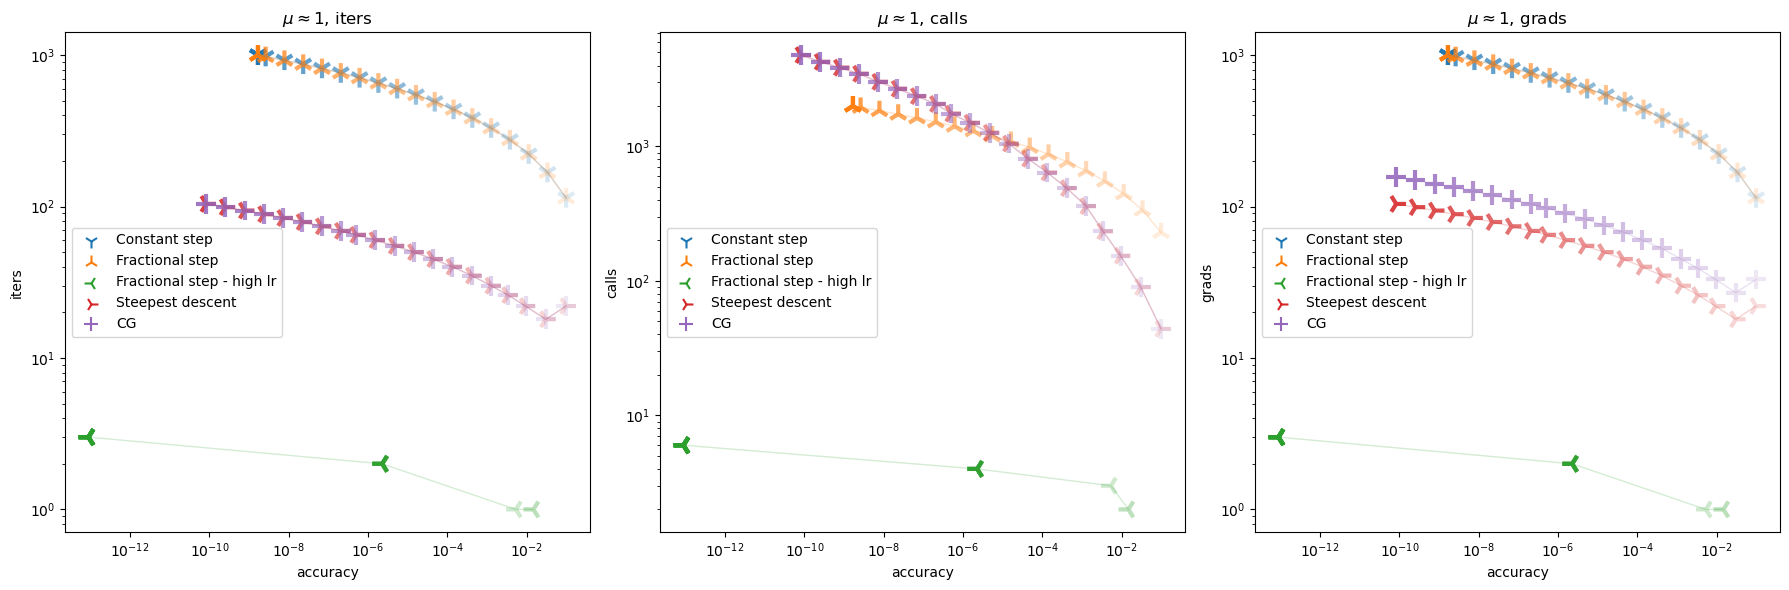

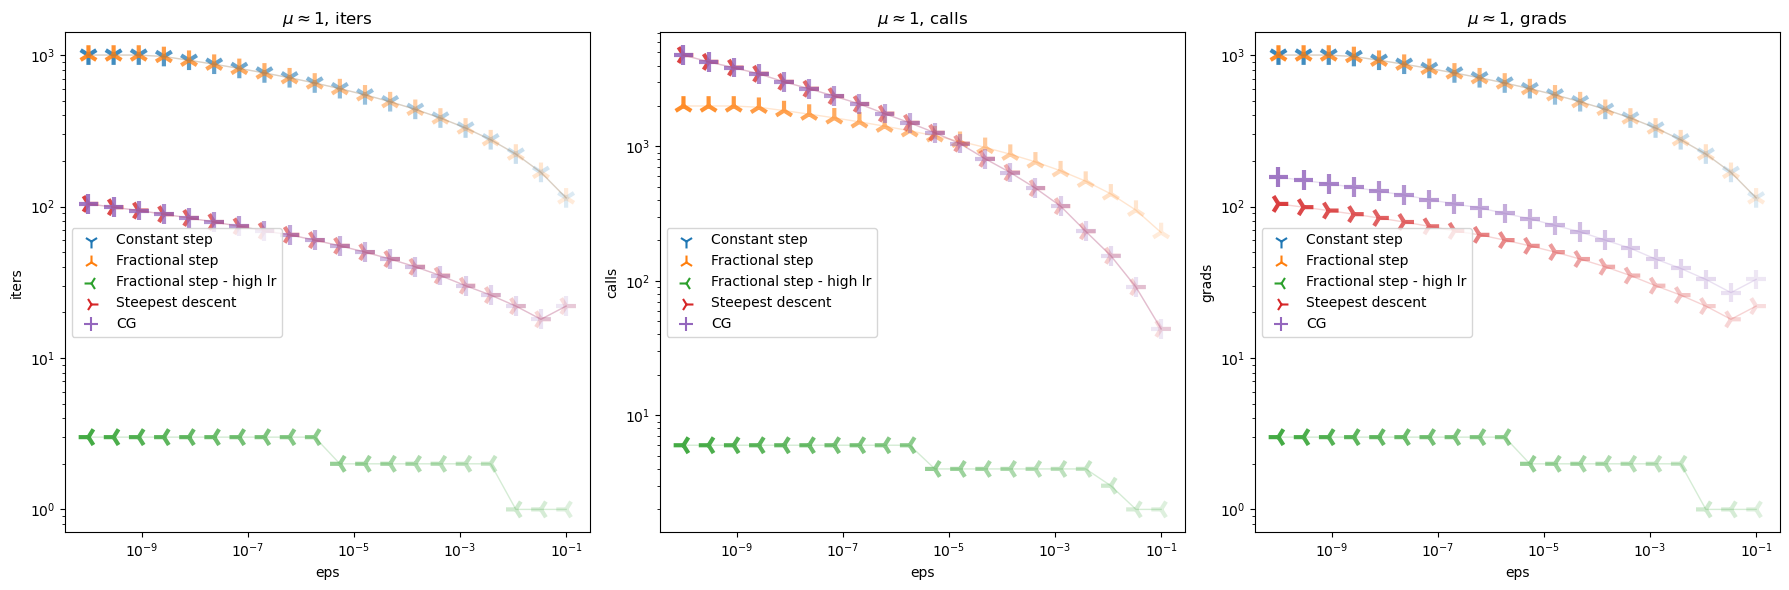

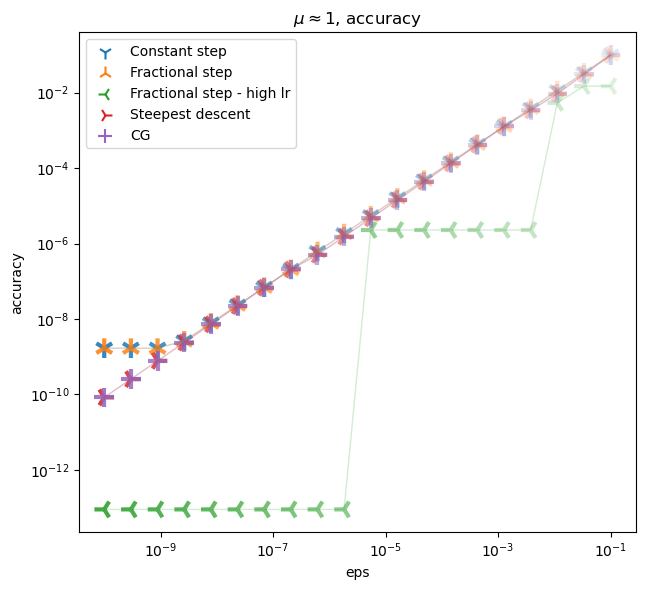

$\mu \approx 10$

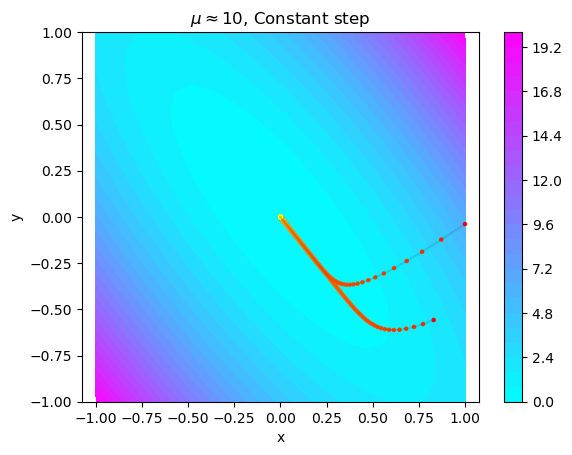

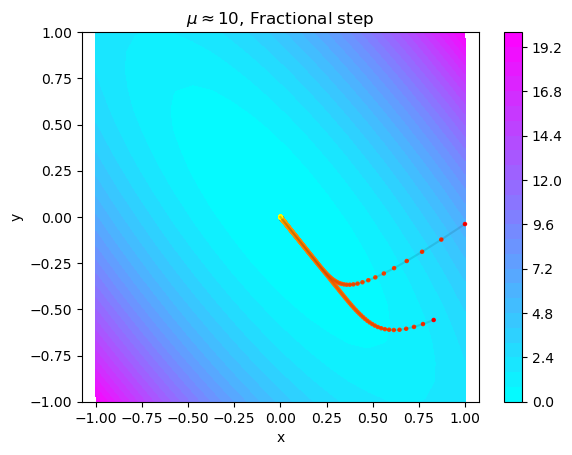

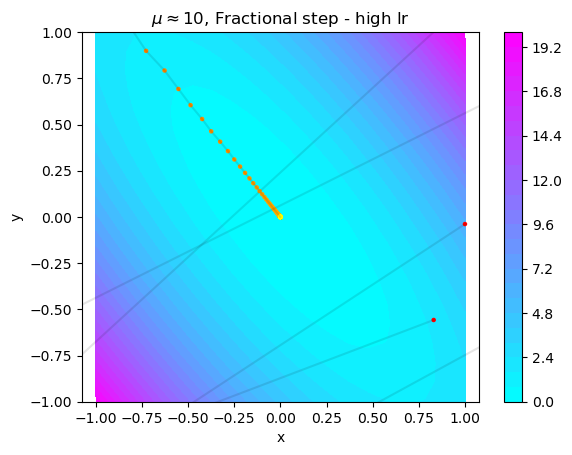

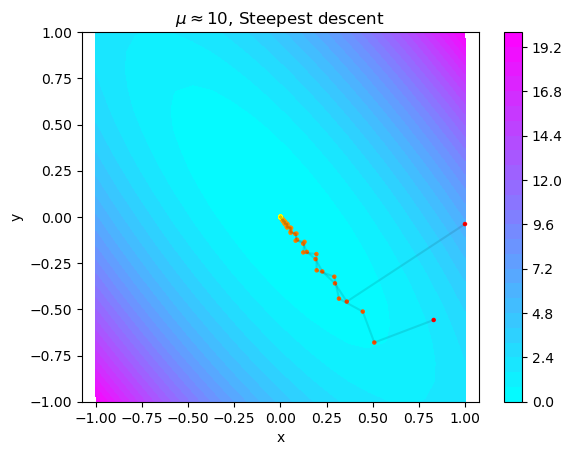

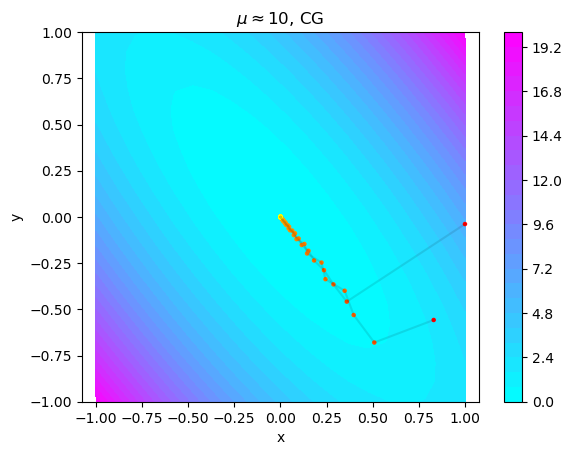

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              9.938688e-02                    102   
1   3.359818e-02              3.338006e-02                    156   
2   1.128838e-02              1.121244e-02                    210   
3   3.792690e-03              3.766160e-03                    264   
4   1.274275e-03              1.265041e-03                    318   
5   4.281332e-04              4.249252e-04                    372   
6   1.438450e-04              1.427318e-04                    426   
7   4.832930e-05              4.794339e-05                    480   
8   1.623777e-05              1.610411e-05                    534   
9   5.455595e-06              5.409348e-06                    588   
10  1.832981e-06              1.816992e-06                    642   
11  6.158482e-07              6.103249e-07                    696   
12  2.069138e-07              2.050072e-07                    750   
13  6.951928e-08              6.886162e-08                    804   
14  2.335721e-08              2.313052e-08                    858   
15  7.847600e-09              7.769506e-09                    912   
16  2.636651e-09              2.609766e-09                    966   
17  8.858668e-10              1.350577e-09                   1000   
18  2.976351e-10              1.350577e-09                   1000   
19  1.000000e-10              1.350577e-09                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                    102                9.938688e-02   
1                       0                    156                3.338006e-02   
2                       0                    210                1.121244e-02   
3                       0                    264                3.766160e-03   
4                       0                    318                1.265041e-03   
5                       0                    372                4.249252e-04   
6                       0                    426                1.427318e-04   
7                       0                    480                4.794339e-05   
8                       0                    534                1.610411e-05   
9                       0                    588                5.409348e-06   
10                      0                    642                1.816992e-06   
11                      0                    696                6.103249e-07   
12                      0                    750                2.050072e-07   
13                      0                    804                6.886162e-08   
14                      0                    858                2.313052e-08   
15                      0                    912                7.769506e-09   
16                      0                    966                2.609766e-09   
17                      0                   1000                1.350577e-09   
18                      0                   1000                1.350577e-09   
19                      0                   1000                1.350577e-09   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                       102                      205                      102   
1                       156                      313                      156   
2                       210                      421                      210   
3                       264                      529                      264   
4                       318                      637                      318   
5                       372                      745                      372   
6                       426                      853                      426   
7                       480                      961                      480   
8                       534                     1069                      534   
9                       588                     1177                    

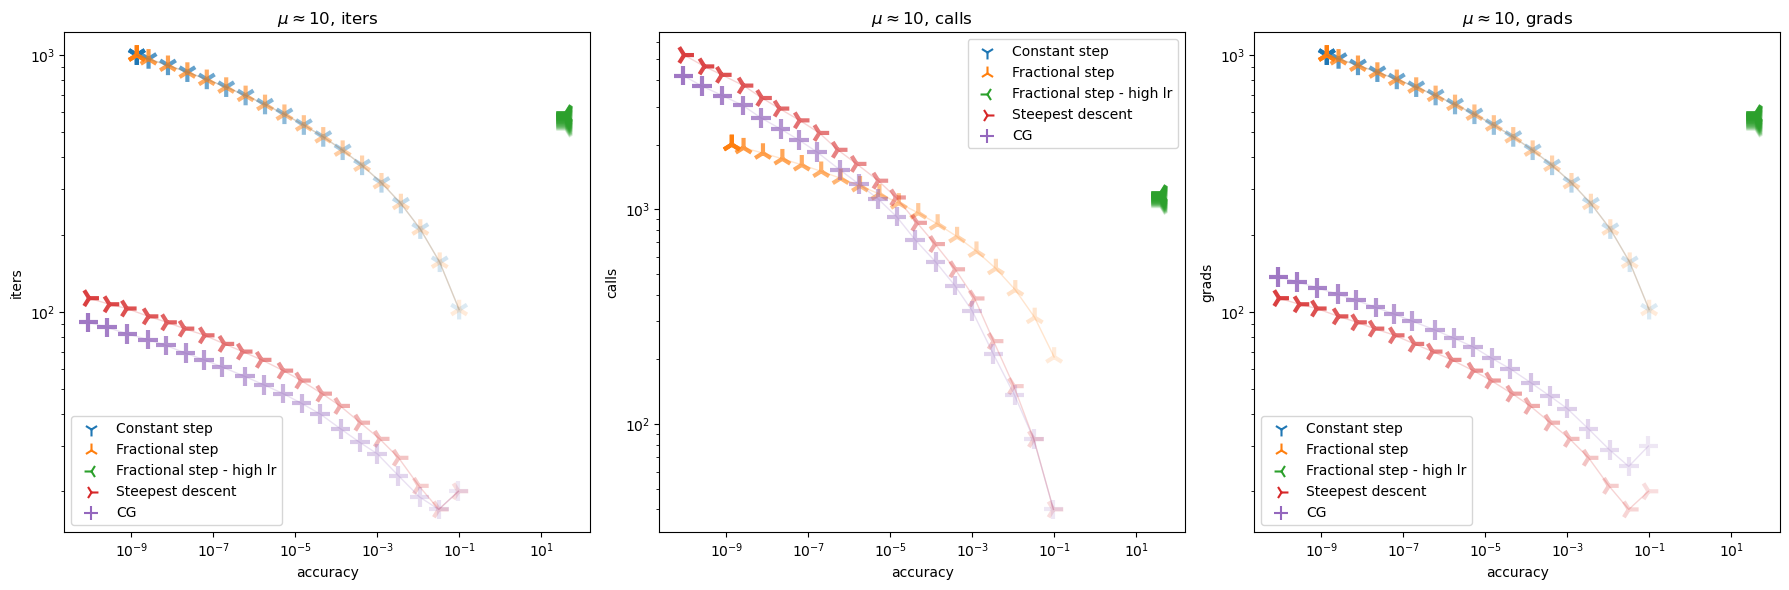

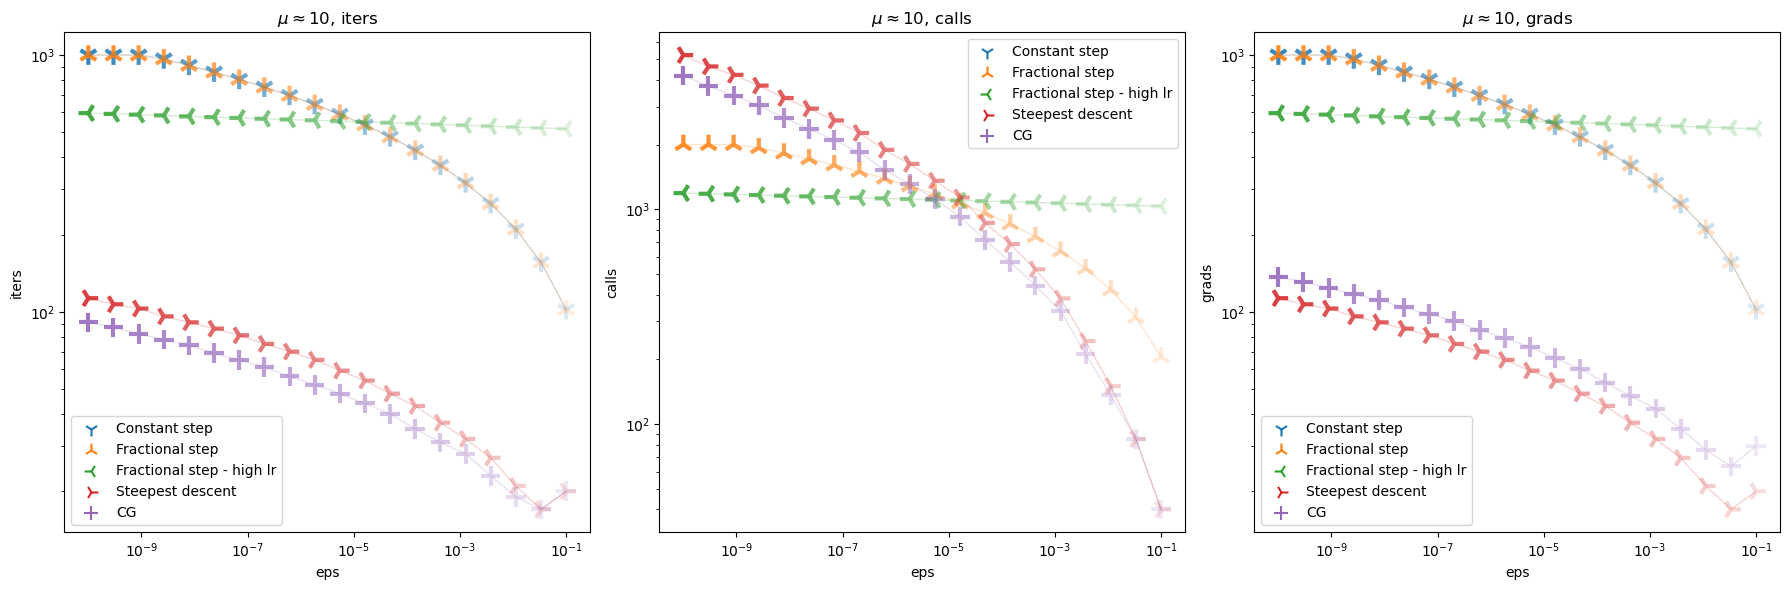

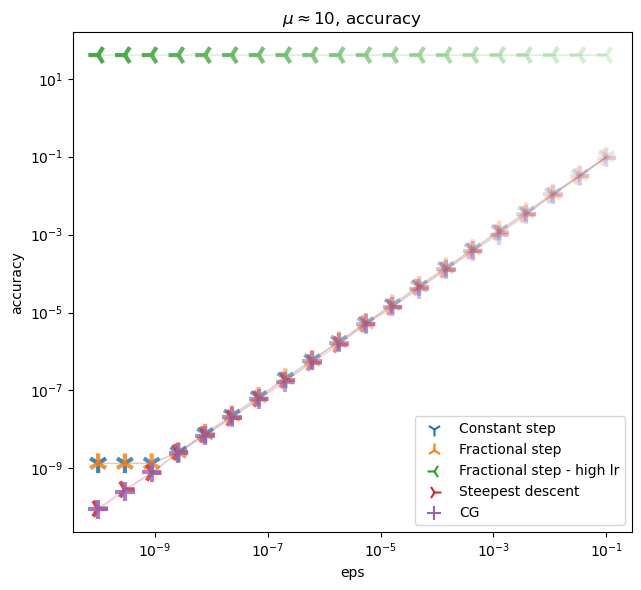

Rosenbrock

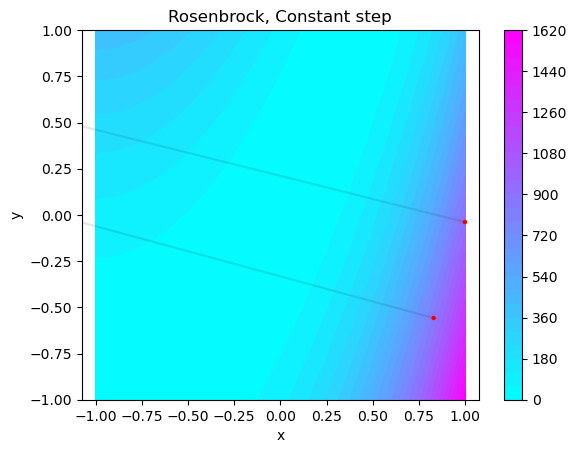

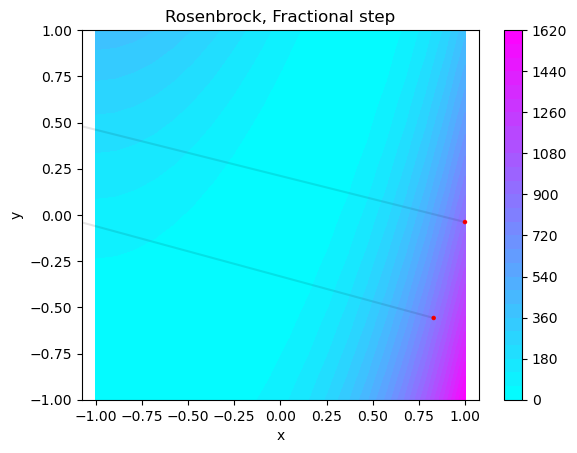

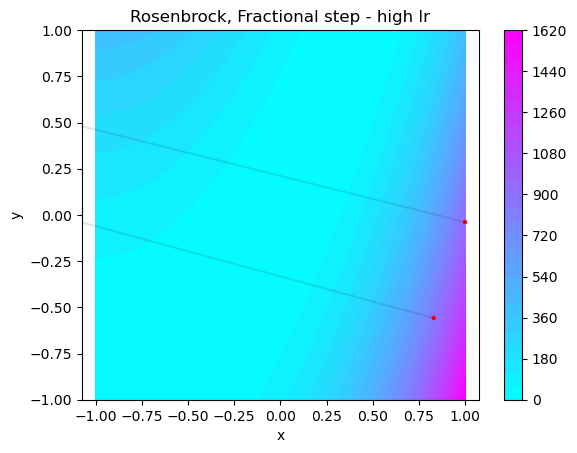

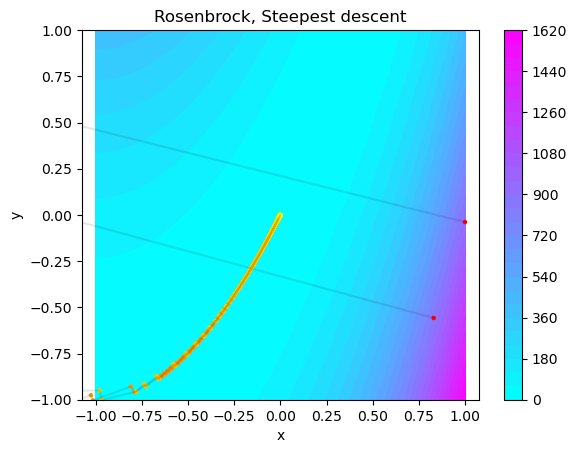

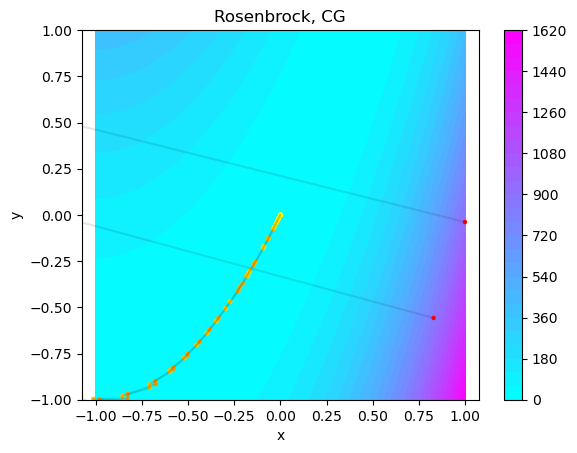

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              64989.970895                   1000   
1   3.359818e-02              64989.970895                   1000   
2   1.128838e-02              64989.970895                   1000   
3   3.792690e-03              64989.970895                   1000   
4   1.274275e-03              64989.970895                   1000   
5   4.281332e-04              64989.970895                   1000   
6   1.438450e-04              64989.970895                   1000   
7   4.832930e-05              64989.970895                   1000   
8   1.623777e-05              64989.970895                   1000   
9   5.455595e-06              64989.970895                   1000   
10  1.832981e-06              64989.970895                   1000   
11  6.158482e-07              64989.970895                   1000   
12  2.069138e-07              64989.970895                   1000   
13  6.951928e-08              64989.970895                   1000   
14  2.335721e-08              64989.970895                   1000   
15  7.847600e-09              64989.970895                   1000   
16  2.636651e-09              64989.970895                   1000   
17  8.858668e-10              64989.970895                   1000   
18  2.976351e-10              64989.970895                   1000   
19  1.000000e-10              64989.970895                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                   1000                   617.74085   
1                       0                   1000                   617.74085   
2                       0                   1000                   617.74085   
3                       0                   1000                   617.74085   
4                       0                   1000                   617.74085   
5                       0                   1000                   617.74085   
6                       0                   1000                   617.74085   
7                       0                   1000                   617.74085   
8                       0                   1000                   617.74085   
9                       0                   1000                   617.74085   
10                      0                   1000                   617.74085   
11                      0                   1000                   617.74085   
12                      0                   1000                   617.74085   
13                      0                   1000                   617.74085   
14                      0                   1000                   617.74085   
15                      0                   1000                   617.74085   
16                      0                   1000                   617.74085   
17                      0                   1000                   617.74085   
18                      0                   1000                   617.74085   
19                      0                   1000                   617.74085   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                      1000                     2000                     1000   
1                      1000                     2000                     1000   
2                      1000                     2000                     1000   
3                      1000                     2000                     1000   
4                      1000                     2000                     1000   
5                      1000                     2000                     1000   
6                      1000                     2000                     1000   
7                      1000                     2000                     1000   
8                      1000                     2000                     1000   
9                      1000                     2000                    

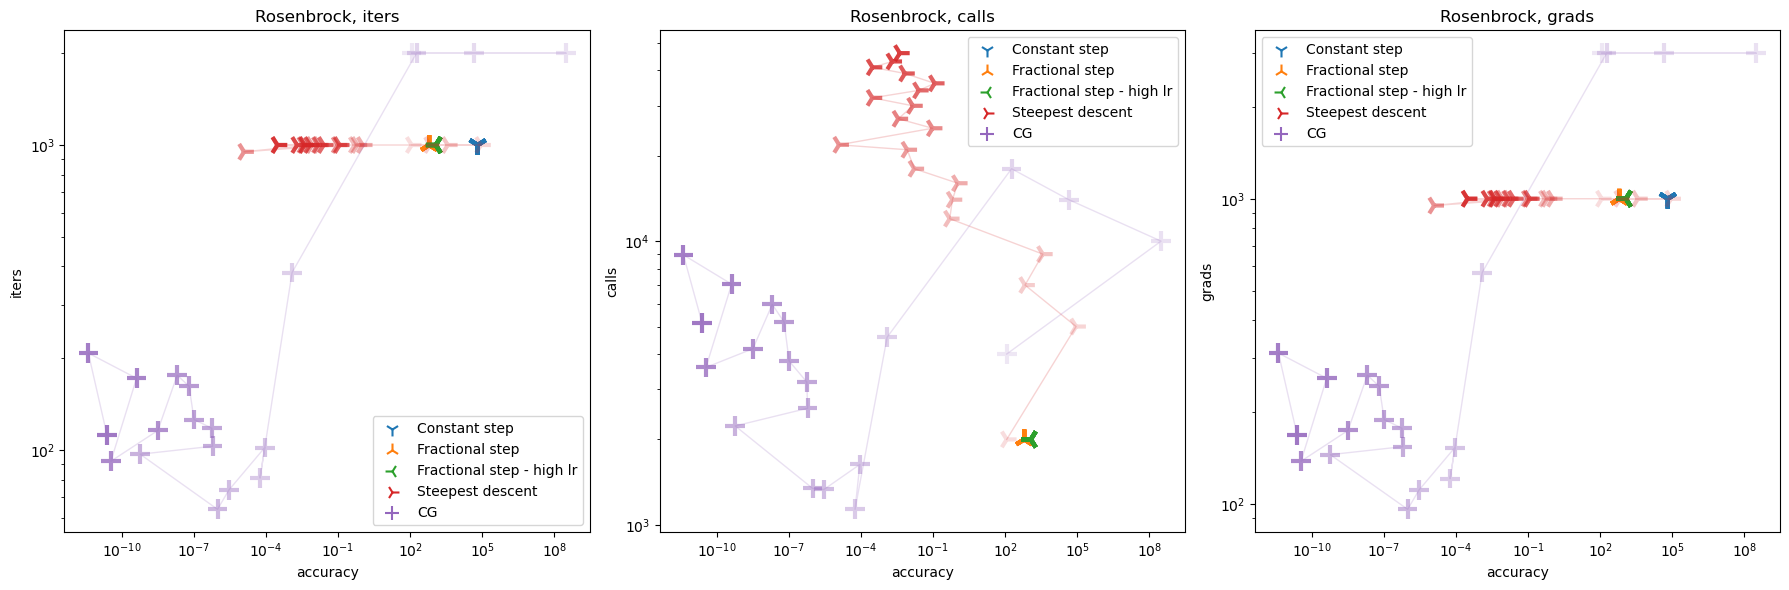

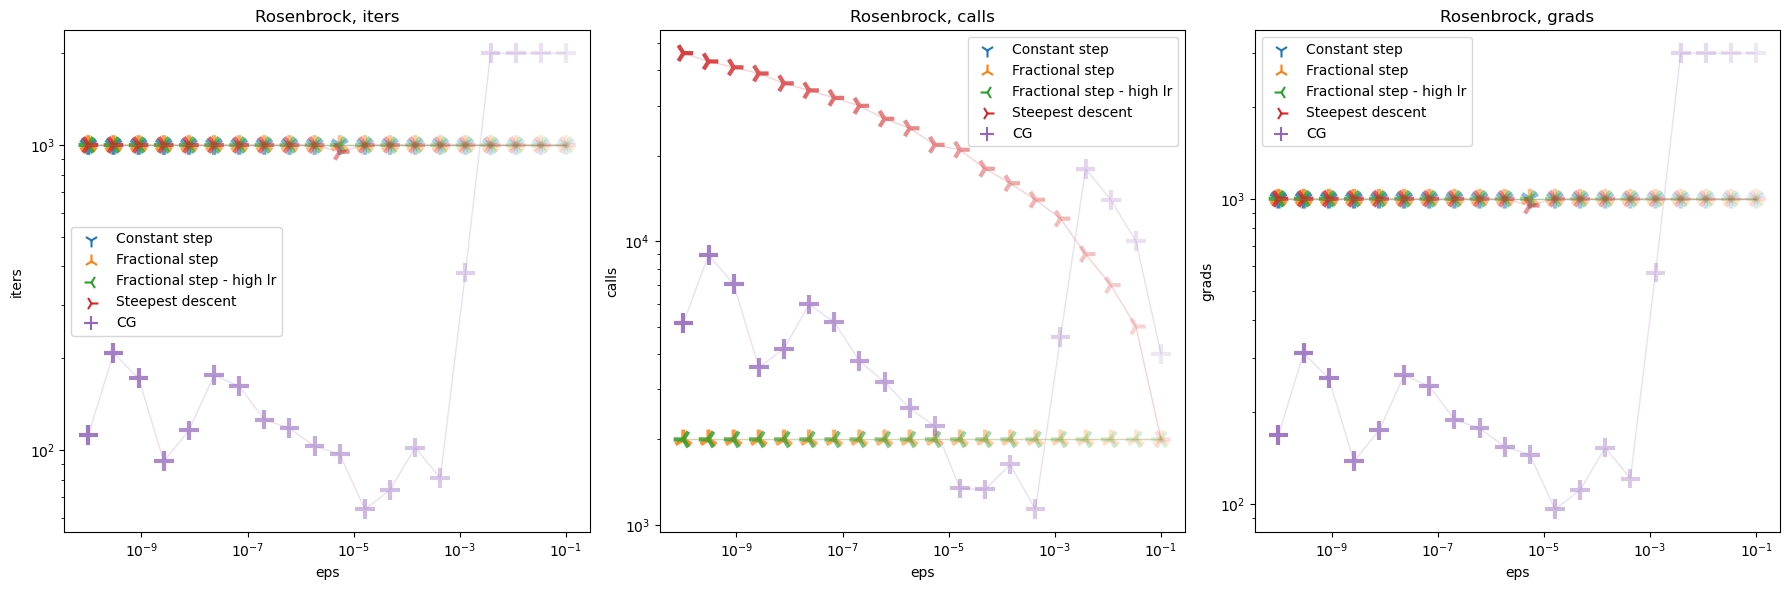

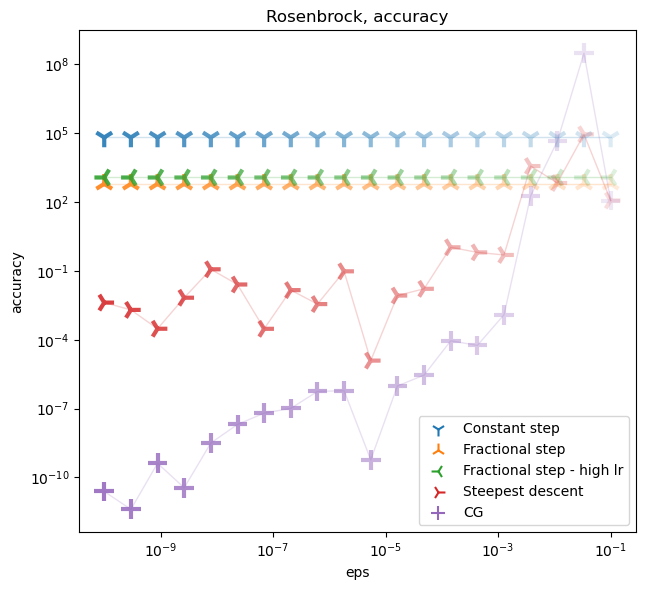

In [48]:
# a, b
functions = [
    (f_a, r"$\mu \approx 1$"),
    (f_b, r"$\mu \approx 10$"),
    (f_c, "Rosenbrock"),
]


def gd_fractional_step_high_lr(*args, lr=1, gamma=1.0, **kwargs):
    return gd_fractional_step(*args, lr=1.0, gamma=1e-1, **kwargs)


methods = [
    (gd_constant_step, "Constant step"),
    (gd_fractional_step, "Fractional step"),
    (gd_fractional_step_high_lr, "Fractional step - high lr"),
    (steepest_descent, "Steepest descent"),
    (conjugate_gradient, "CG"),
]


def make_tables(
    functions: list[tuple[Callable, str]],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_tables: bool = False,
):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]

    for f, f_name in functions:
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:

            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                x, y = np.meshgrid(xl, yl)
                z = 0 * x * y
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = f(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(x, y, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(x, y, z, levels=levels, cmap="cool")
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # solve
                    p = point.copy()
                    result, iters, calls, grad_calls, trajectory = method(
                        f, p, eps=eps, info=True
                    )
                    if ideps + 1 == len(EPS):
                        trajectory = np.array(trajectory)
                        x, y = trajectory.T[0], trajectory.T[1]
                        # print(x[0],y[0])
                        x, y = x, y
                        c = [(q / len(x)) ** 0.25 for q in range(len(x))]
                        plt.plot(x, y, color="black", alpha=0.1)
                        plt.scatter(x, y, c=c, s=5, cmap="autumn")
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data[method_name + " (accuracy)"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("accuracy")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18, 6))
            for plot_idx, plot_type in enumerate(["accuracy"]):
                plt.subplot(1, 3, plot_idx + 1)
                plt.title(f_name + ", " + plot_type)
                for method_id, (method, method_name) in enumerate(methods):
                    alpha = [
                        (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                        for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                    ]
                    (c,) = plt.plot([], [])
                    c = c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter(
                            [],
                            [],
                            label=method_name,
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            s=100,
                            c=c,
                        )
                        plt.scatter(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            marker=str(method_id + 1) if method_id < 4 else "+",
                            alpha=alpha,
                            s=200,
                            c=c,
                            lw=3,
                        )
                        plt.plot(
                            data["eps"],
                            data[method_name + f" ({plot_type})"],
                            alpha=0.2,
                            c=c,
                            lw=1,
                        )
                        plt.xscale("log")
                        plt.yscale("log")
                plt.xlabel("eps")
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()


pd.set_option("display.max_columns", None)

make_tables(functions, methods, plot_tables=True)

#### 4

For the Rosenbrock function, plot and compare the trajectories of each method on the level line plot.


Rosenbrock

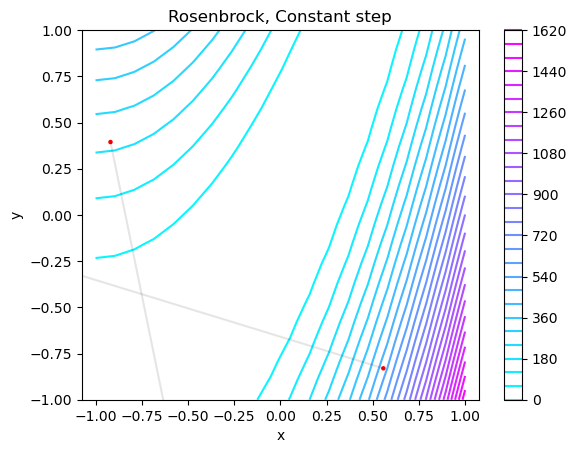

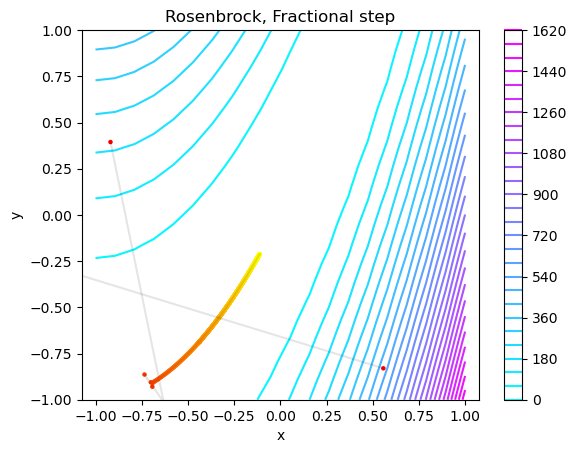

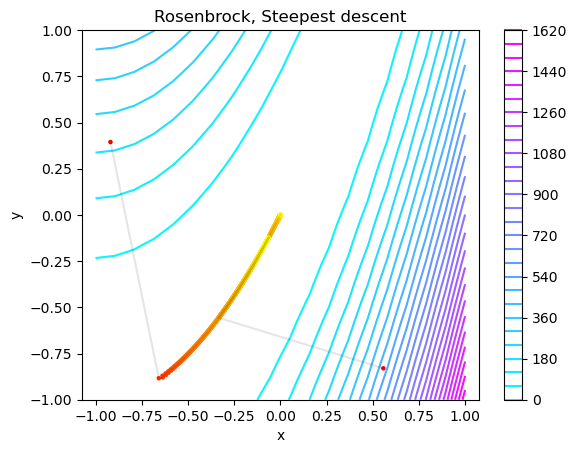

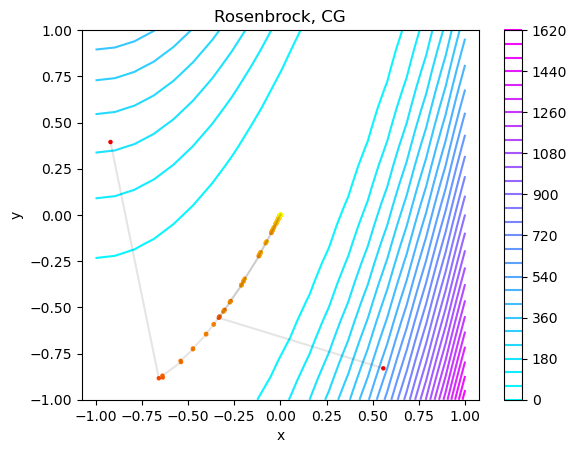

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01               3296.383205                   1000   
1   3.359818e-02               3296.383205                   1000   
2   1.128838e-02               3296.383205                   1000   
3   3.792690e-03               3296.383205                   1000   
4   1.274275e-03               3296.383205                   1000   
5   4.281332e-04               3296.383205                   1000   
6   1.438450e-04               3296.383205                   1000   
7   4.832930e-05               3296.383205                   1000   
8   1.623777e-05               3296.383205                   1000   
9   5.455595e-06               3296.383205                   1000   
10  1.832981e-06               3296.383205                   1000   
11  6.158482e-07               3296.383205                   1000   
12  2.069138e-07               3296.383205                   1000   
13  6.951928e-08               3296.383205                   1000   
14  2.335721e-08               3296.383205                   1000   
15  7.847600e-09               3296.383205                   1000   
16  2.636651e-09               3296.383205                   1000   
17  8.858668e-10               3296.383205                   1000   
18  2.976351e-10               3296.383205                   1000   
19  1.000000e-10               3296.383205                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                   1000                   70.642568   
1                       0                   1000                   70.642568   
2                       0                   1000                   70.642568   
3                       0                   1000                   70.642568   
4                       0                   1000                   70.642568   
5                       0                   1000                   70.642568   
6                       0                   1000                   70.642568   
7                       0                   1000                   70.642568   
8                       0                   1000                   70.642568   
9                       0                   1000                   70.642568   
10                      0                   1000                   70.642568   
11                      0                   1000                   70.642568   
12                      0                   1000                   70.642568   
13                      0                   1000                   70.642568   
14                      0                   1000                   70.642568   
15                      0                   1000                   70.642568   
16                      0                   1000                   70.642568   
17                      0                   1000                   70.642568   
18                      0                   1000                   70.642568   
19                      0                   1000                   70.642568   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                      1000                     2000                     1000   
1                      1000                     2000                     1000   
2                      1000                     2000                     1000   
3                      1000                     2000                     1000   
4                      1000                     2000                     1000   
5                      1000                     2000                     1000   
6                      1000                     2000                     1000   
7                      1000                     2000                     1000   
8                      1000                     2000                     1000   
9                      1000                     2000                    

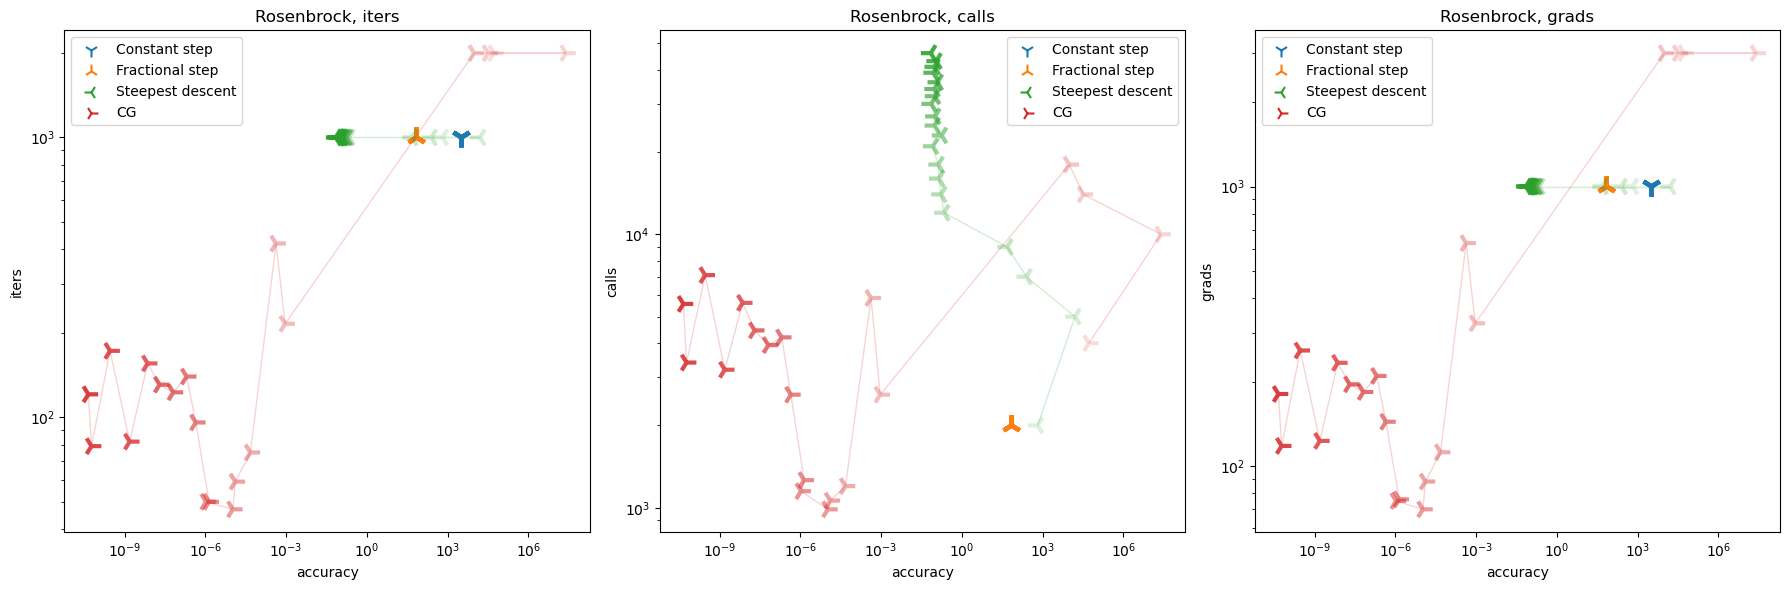

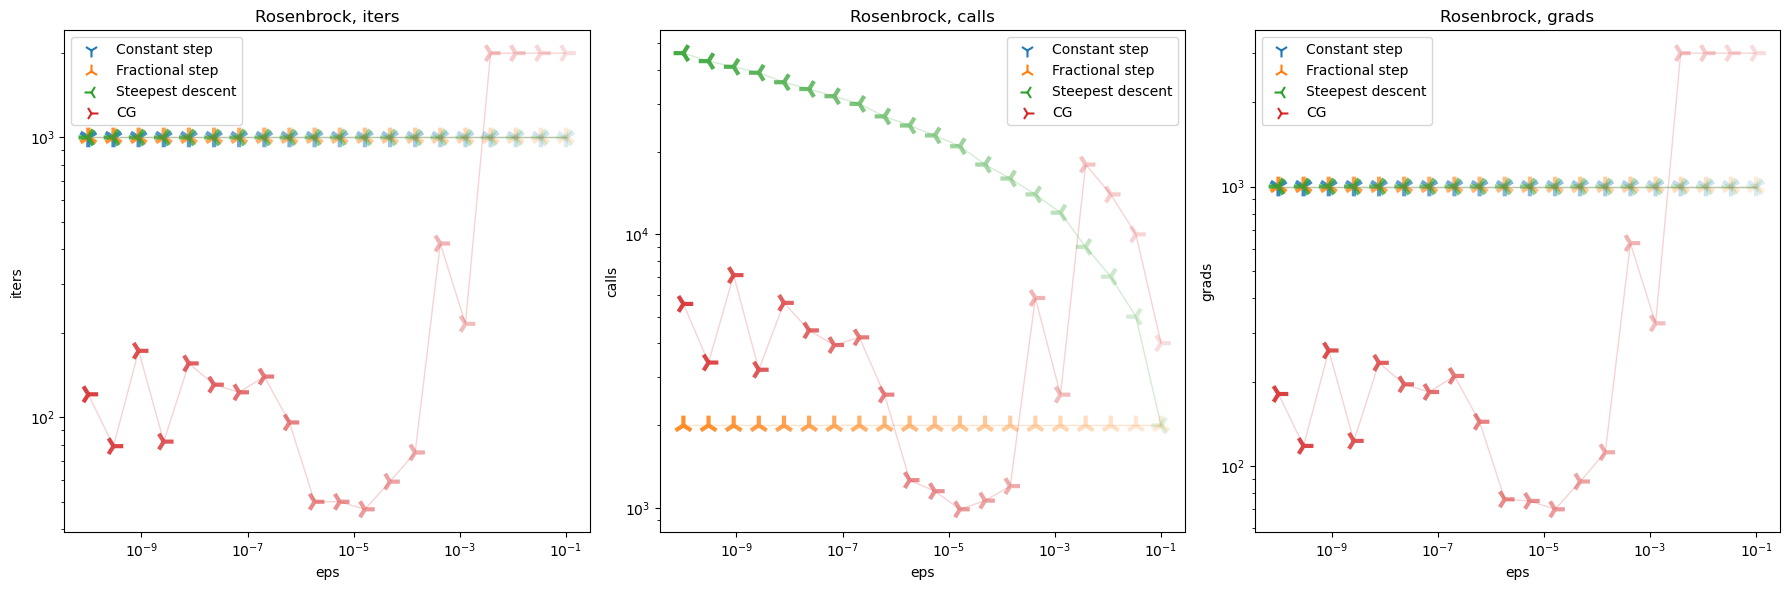

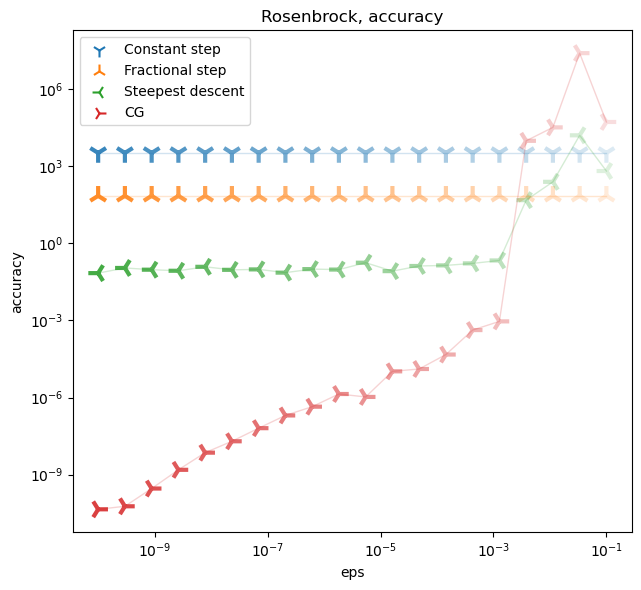

In [ ]:
# just like the previous task, but with contour:
# a, b
functions = [
    (f_c, "Rosenbrock"),
]
methods = [
    (gd_constant_step, "Constant step"),
    (gd_fractional_step, "Fractional step"),
    (steepest_descent, "Steepest descent"),
    (conjugate_gradient, "CG"),
]

make_tables(functions, methods, plot_tables=True, contour=True)


#### 5

Implement a generator of quadratic functions of a given dimension and condition number. Investigate the dependence of the number of iterations that must be performed to achieve the selected accuracy, depending on these parameters. Consider this dependence for two gradient methods, one of which is (necessarily) the conjugate gradient method.


In [ ]:
# creation of quadratic function
# with given condition number
# A should be positive-definite and simmetric for all methods to work
# thus,
# let A = (B.T + B)/2 (to be simmetric)
# Since it is known that G.T @ G is a positive definite matrix
# (if G is invertible),
# let B = G.T @ G
#
# To generate arbitrary invertable matrix G,
# it is enough to make a orthogonal transform of a diagonal matrix.
#
# To generate an arbitrary orthogonal transformation,
# QR decomposition of a real random matrix C can be used.


In [ ]:
def generator(mu: float, n: int) -> Callable[[np.ndarray], float]:
    assert mu >= 1
    # c = 0 if mu > 1 else mu / 100
    if n < 1:
        return None
    if n == 1:
        return lambda x: mu * x
    w = np.sqrt(mu)
    D = np.diag([w] + list(np.random.random(n - 2) * (w - 1) + 1) + [1 if w > 1 else w])
    C = np.random.random((n, n))
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B) / 2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    if w >= 1:
        assert np.isclose(np.linalg.cond(A), mu)
    return lambda x: x.T @ A @ x


def test_generator():
    generator(1, 1)
    generator(2, 2)
    generator(3, 2)
    generator(4, 2)
    generator(4, 4)
    generator(1, 2)


test_generator()


In [ ]:
methods = [
    (gd_constant_step, "Constant step"),
    (conjugate_gradient, "CG"),
]


def investigate_iter_vs_accuracy(
    mus: list[float],
    methods: list[tuple[Callable, str]],
    contour: bool = False,
    plot_table: bool = False,
    plot_illustrations=False,
):
    num_of_random_points = 5
    radius = 1
    n_countour_points = 20
    levels = 30
    functions = [(generator(mu, 2), r"$\mu = " + str(mu) + "$") for mu in mus]
    eps = 1e-7
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2 * np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2 * np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]

    data = dict()
    data["mus"] = mus
    for f, f_name in functions:
        if plot_illustrations:
            print()
            display(Markdown(f_name))
            plt.figure(figsize=(6 * len(methods), 6))
        for method_id, (method, method_name) in enumerate(methods):

            def plot_contours():
                plt.title(f_name + ", " + method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                x, y = np.meshgrid(xl, yl)
                z = 0 * x * y
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = f(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(x, y, z, levels=levels, cmap="cool")
                else:
                    plt.contourf(x, y, z, levels=levels, cmap="cool")
                plt.colorbar()

            if plot_illustrations:
                plt.subplot(1, len(methods), method_id + 1)
                plot_contours()
            acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                [],
                [],
                [],
                [],
            )
            for point in random_points:
                # solve
                p = point.copy()
                result, iters, calls, grad_calls, trajectory = method(
                    f, p, eps=eps, info=True
                )
                if plot_illustrations:
                    trajectory = np.array(trajectory)
                    x, y = trajectory.T[0], trajectory.T[1]
                    # print(x[0],y[0])
                    x, y = x[::5], y[::5]
                    c = [(q / len(x)) ** 0.25 for q in range(len(x))]
                    plt.plot(x, y, color="black", alpha=0.1)
                    plt.scatter(x, y, c=c, cmap="autumn")
                acc_multipoint.append(np.linalg.norm(result - np.zeros_like(result)))
                iters_multipoint.append(iters)
                calls_multipoint.append(calls)
                grad_multipoint.append(grad_calls)
            acc_total = np.mean(acc_multipoint)
            iters_total = int(np.mean(iters_multipoint))
            calls_total = int(np.mean(calls_multipoint))
            grad_total = int(np.mean(grad_multipoint))
            if plot_illustrations:
                plt.xlim(xlim)
                plt.ylim(ylim)
            data.setdefault(method_name + " (accuracy)", []).append(acc_total)
            data.setdefault(method_name + " (iters)", []).append(iters_total)
            data.setdefault(method_name + " (calls)", []).append(calls_total)
            data.setdefault(method_name + " (grads)", []).append(grad_total)
        if plot_illustrations:
            plt.show()
    data = pd.DataFrame(data)
    display(data)
    if plot_table:
        # accuracy
        plt.figure(figsize=(18, 6))
        for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
            plt.subplot(1, 3, plot_idx + 1)
            plt.title(plot_type)
            for method_id, (method, method_name) in enumerate(methods):
                alpha = [
                    (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                    for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                ]
                (c,) = plt.plot([], [])
                c = c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter(
                        [], [], label=method_name, marker=str(method_id + 1), s=100, c=c
                    )
                    plt.scatter(
                        data[method_name + " (accuracy)"],
                        data[method_name + f" ({plot_type})"],
                        marker=str(method_id + 1),
                        alpha=alpha,
                        s=200,
                        c=c,
                        lw=3,
                    )
                    plt.plot(
                        data[method_name + " (accuracy)"],
                        data[method_name + f" ({plot_type})"],
                        alpha=0.2,
                        c=c,
                        lw=1,
                    )
                    plt.xscale("log")
                    plt.yscale("log")
            plt.xlabel("accuracy")
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()
        # mus
        plt.figure(figsize=(18, 6))
        for plot_idx, plot_type in enumerate(["iters", "calls", "grads"]):
            plt.subplot(1, 3, plot_idx + 1)
            plt.title(plot_type)
            for method_id, (method, method_name) in enumerate(methods):
                alpha = [
                    (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                    for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                ]
                (c,) = plt.plot([], [])
                c = c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter(
                        [], [], label=method_name, marker=str(method_id + 1), s=100, c=c
                    )
                    plt.scatter(
                        data["mus"],
                        data[method_name + f" ({plot_type})"],
                        marker=str(method_id + 1),
                        alpha=alpha,
                        s=200,
                        c=c,
                        lw=3,
                    )
                    plt.plot(
                        data["mus"],
                        data[method_name + f" ({plot_type})"],
                        alpha=0.2,
                        c=c,
                        lw=1,
                    )
                    plt.xscale("log")
                    plt.yscale("log")
            plt.xlabel("mus")
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()
        # mus vs accuracy
        plt.figure(figsize=(18, 6))
        for plot_idx, plot_type in enumerate(["accuracy"]):
            plt.subplot(1, 3, plot_idx + 1)
            plt.title(plot_type)
            for method_id, (method, method_name) in enumerate(methods):
                alpha = [
                    (0.2 + idx / len(data[method_name + f" ({plot_type})"])) / 1.3
                    for idx, d in enumerate(data[method_name + f" ({plot_type})"])
                ]
                (c,) = plt.plot([], [])
                c = c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter(
                        [], [], label=method_name, marker=str(method_id + 1), s=100, c=c
                    )
                    plt.scatter(
                        data["mus"],
                        data[method_name + f" ({plot_type})"],
                        marker=str(method_id + 1),
                        alpha=alpha,
                        s=200,
                        c=c,
                        lw=3,
                    )
                    plt.plot(
                        data["mus"],
                        data[method_name + f" ({plot_type})"],
                        alpha=0.2,
                        c=c,
                        lw=1,
                    )
                    plt.xscale("log")
                    plt.yscale("log")
            plt.xlabel("mus")
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()


$\mu = 1.0$

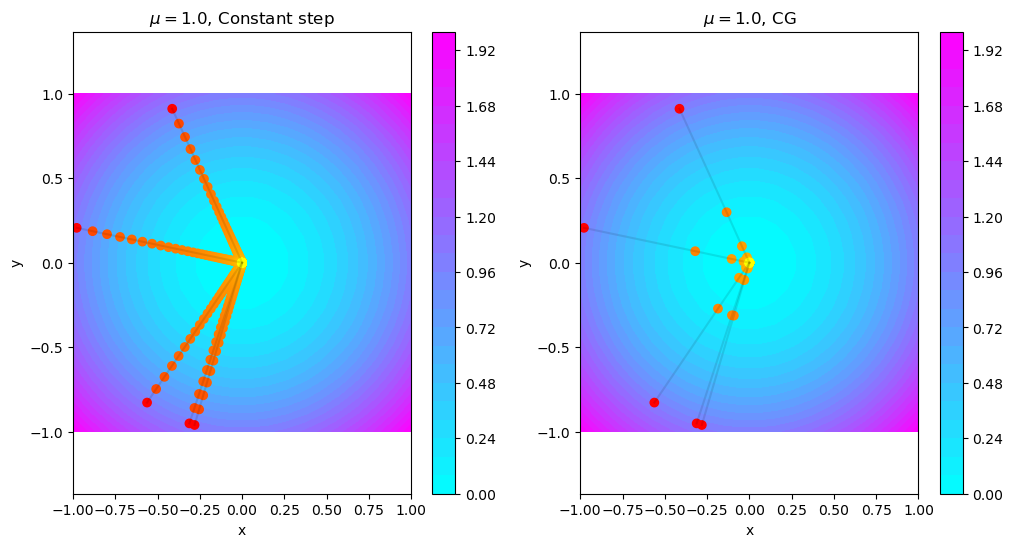

$\mu = 2.154434690031884$

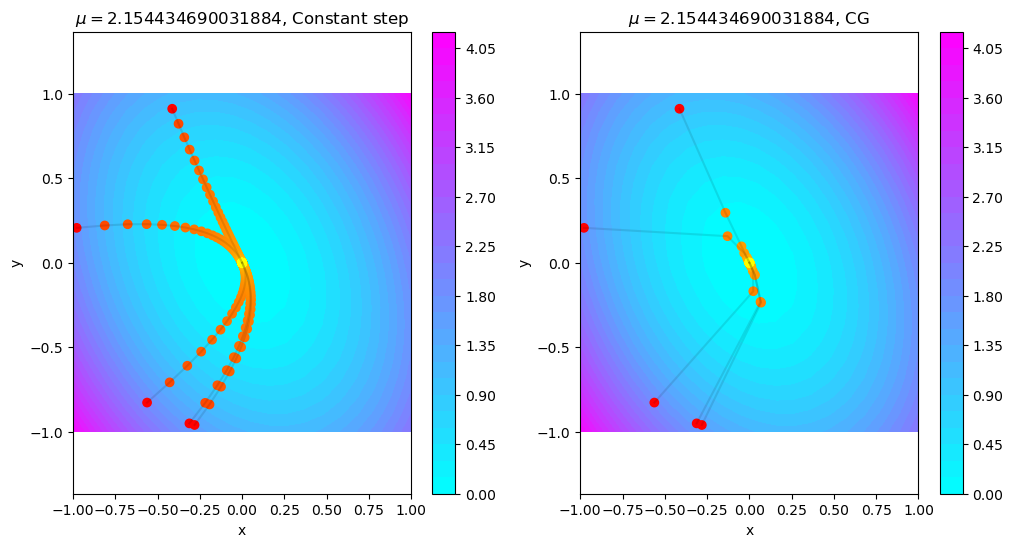

$\mu = 4.641588833612778$

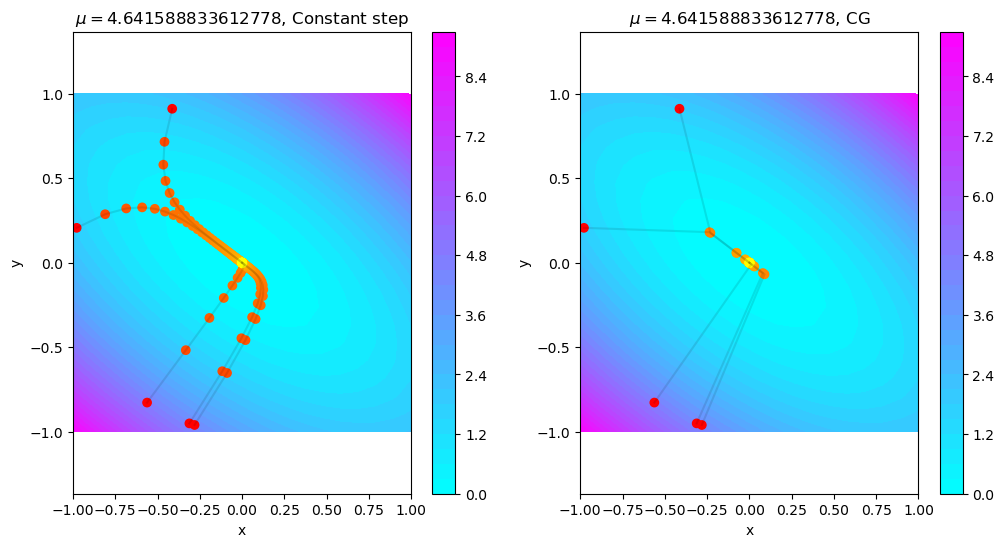

$\mu = 10.0$

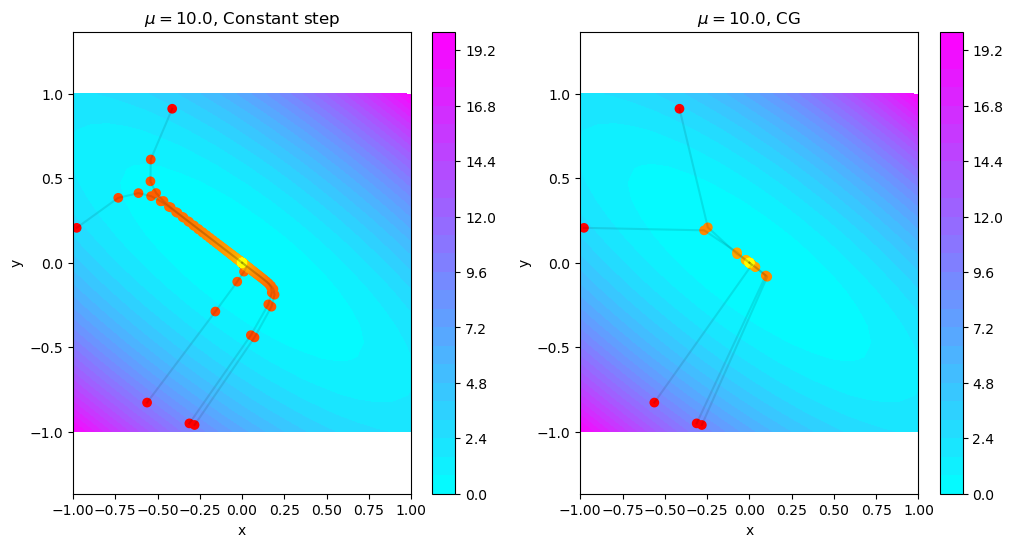

$\mu = 21.544346900318832$

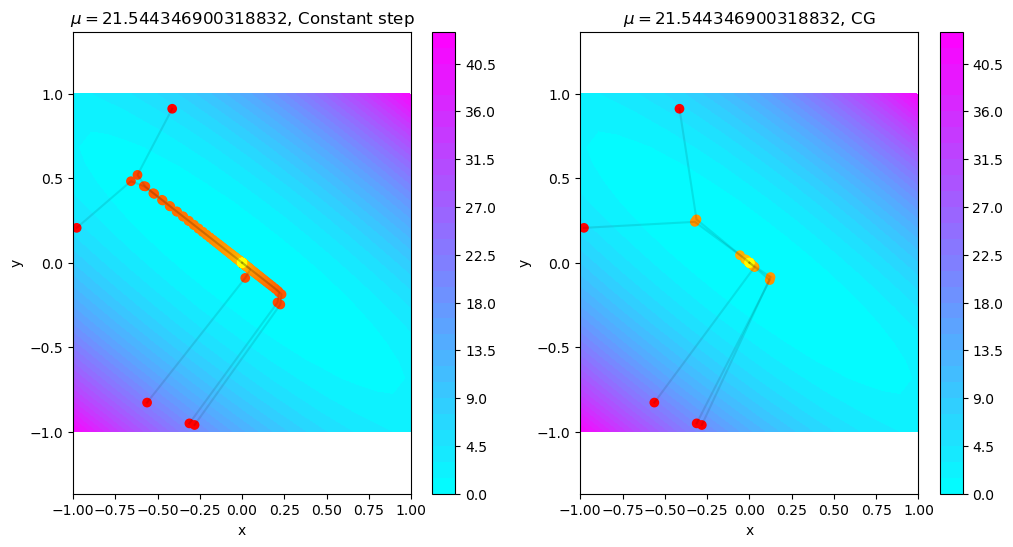

$\mu = 46.41588833612777$

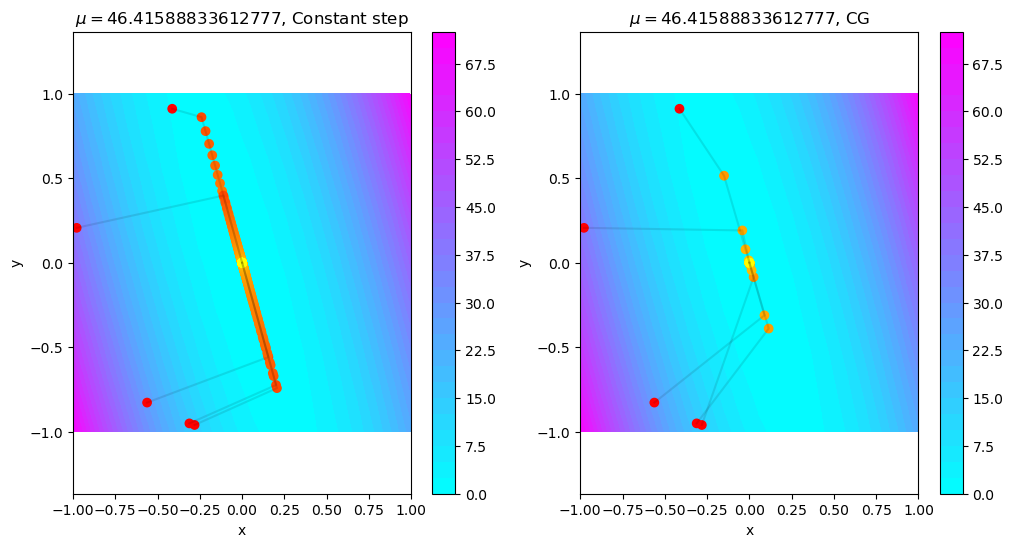

$\mu = 100.0$

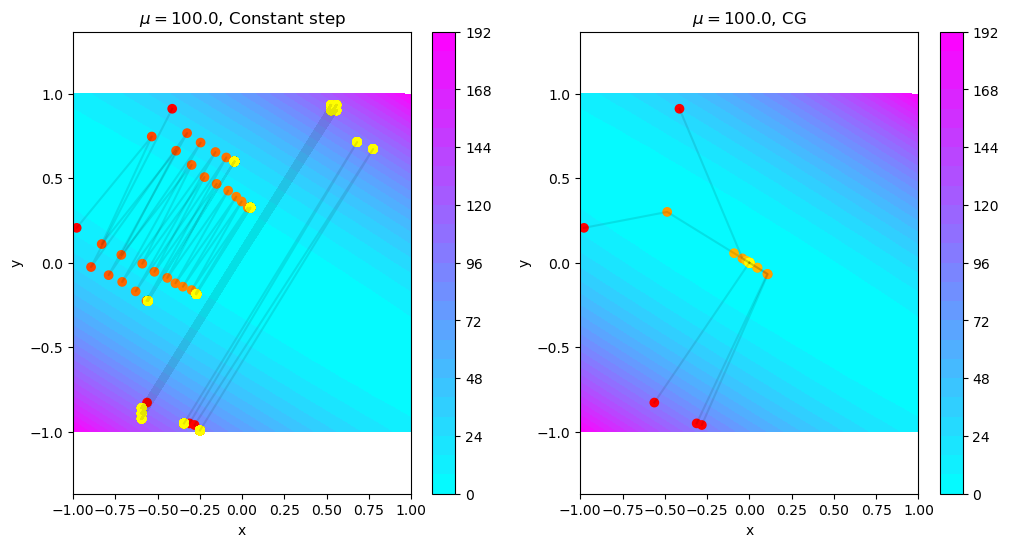

$\mu = 215.44346900318823$

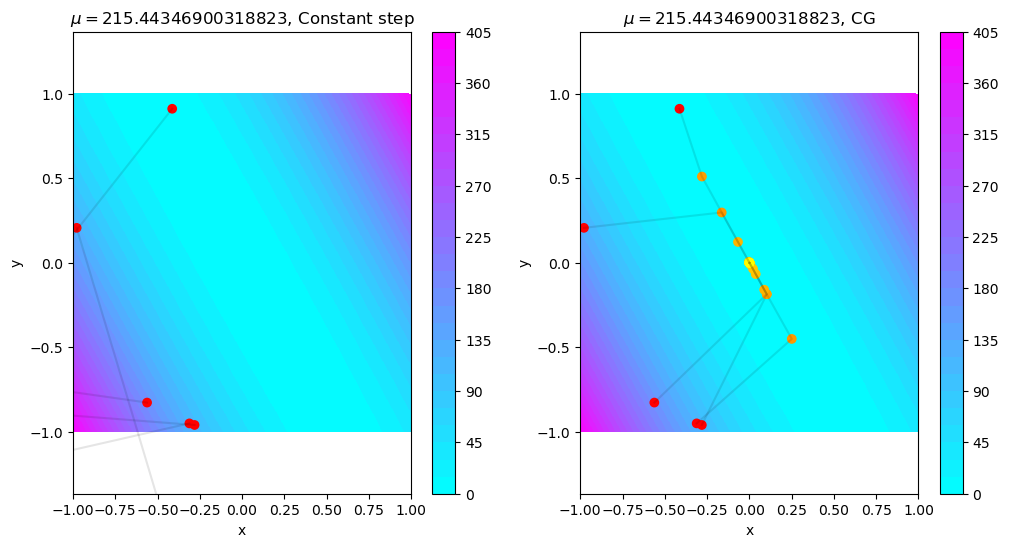

$\mu = 464.15888336127773$

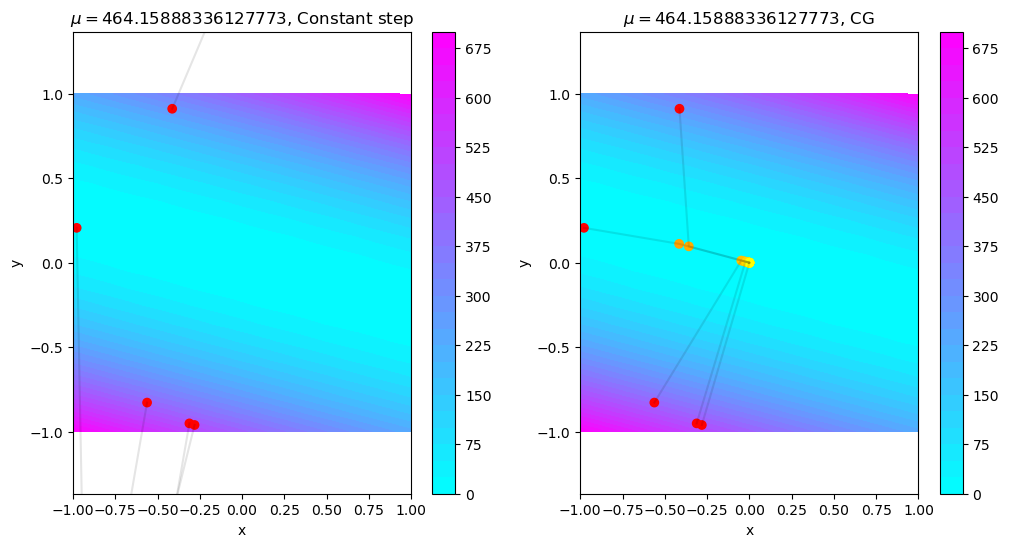

$\mu = 1000.0$

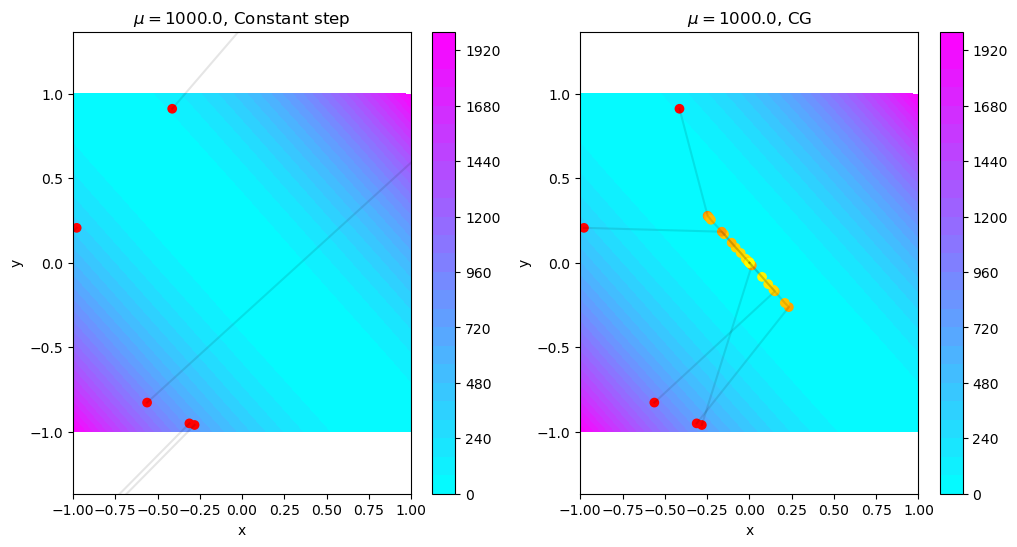

mus  Constant step (accuracy)  Constant step (iters)  \
0     1.000000              9.952726e-08                    798   
1     2.154435              9.886804e-08                    780   
2     4.641589              9.906338e-08                    746   
3    10.000000              9.944517e-08                    746   
4    21.544347              9.915012e-08                    750   
5    46.415888              9.937369e-08                    782   
6   100.000000              8.011530e-01                   1000   
7   215.443469              1.438494e+02                   1000   
8   464.158883              1.522240e+02                   1000   
9  1000.000000              1.224462e+02                   1000   

   Constant step (calls)  Constant step (grads)  CG (accuracy)  CG (iters)  \
0                      0                    798   8.417437e-08          73   
1                      0                    780   9.151942e-08          71   
2                      0                    746   9.210202e-08          67   
3                      0                    746   8.876083e-08          61   
4                      0                    750   7.581769e-08          45   
5                      0                    782   4.952378e-08          35   
6                      0                   1000   6.730641e-08          36   
7                      0                   1000   5.217191e-08          37   
8                      0                   1000   3.375975e-08          21   
9                      0                   1000   5.473929e-08          37   

   CG (calls)  CG (grads)  
0        2263         110  
1        2201         106  
2        2095         101  
3        1903          92  
4        1407          68  
5        1085          52  
6        1128          54  
7        1153          55  
8         669          32  
9        1165          56

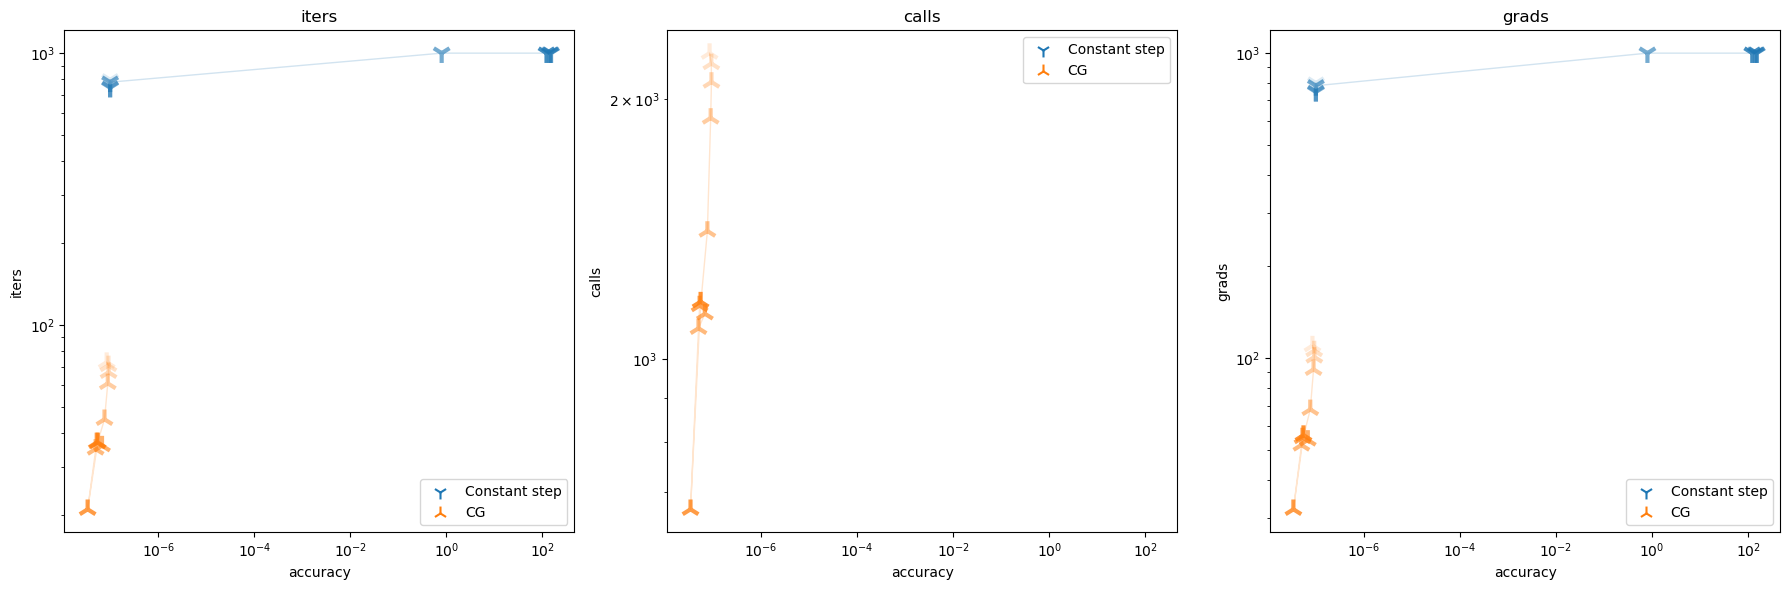

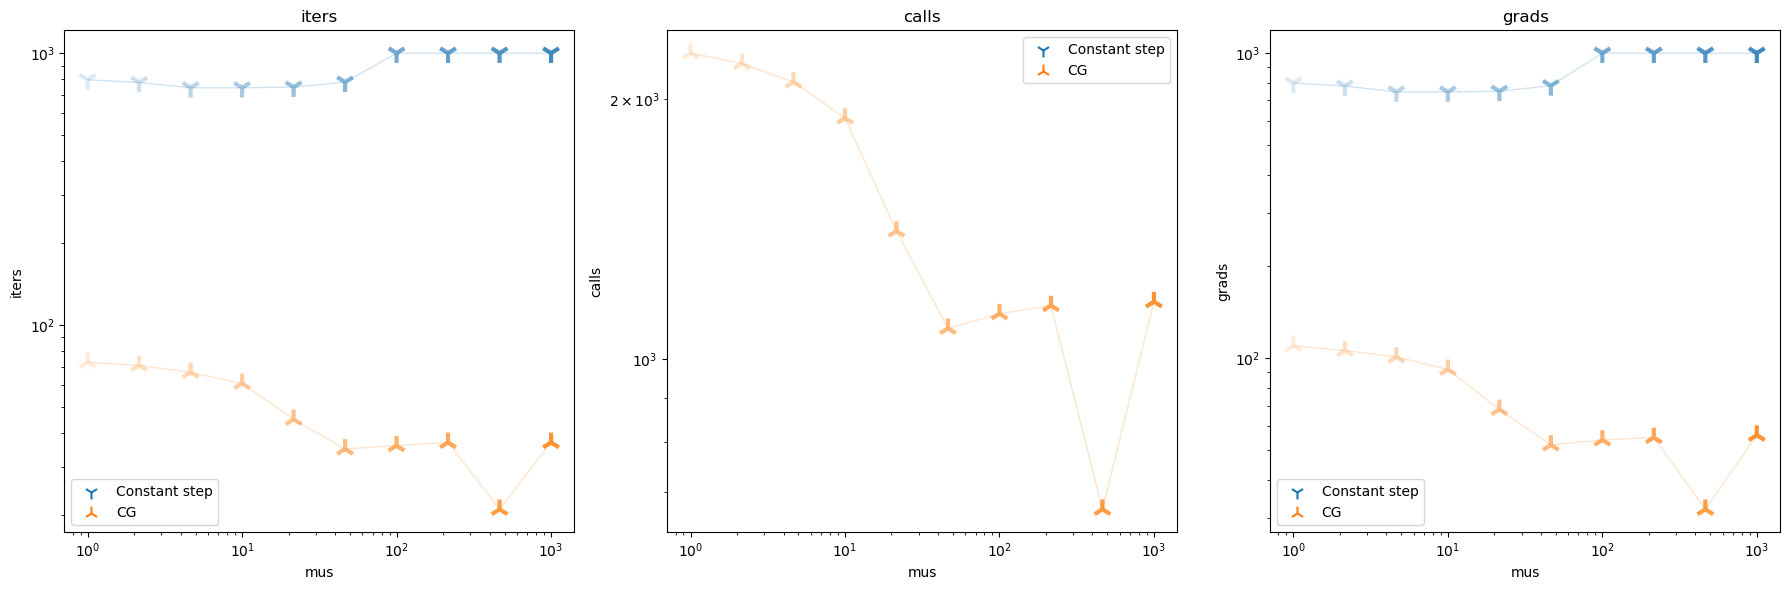

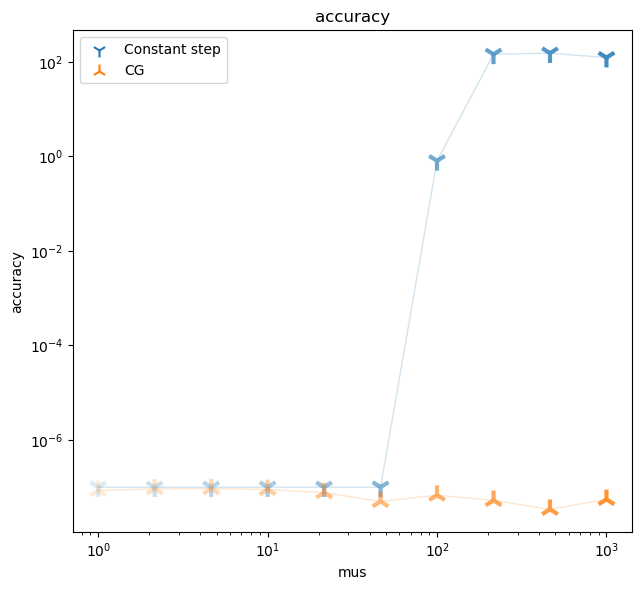

In [ ]:
mus = np.logspace(0, 3, 10)
investigate_iter_vs_accuracy(mus, methods, plot_table=True, plot_illustrations=True)


mus  Constant step (accuracy)  Constant step (iters)  \
0    1.000000              9.961436e-08                    798   
1    1.162833              9.894224e-08                    759   
2    1.352180              9.849410e-08                    786   
3    1.572359              9.883132e-08                    788   
4    1.828391              9.923348e-08                    787   
5    2.126112              9.895095e-08                    740   
6    2.472313              9.920829e-08                    783   
7    2.874886              9.913855e-08                    783   
8    3.343012              9.897097e-08                    783   
9    3.887364              9.882024e-08                    772   
10   4.520354              9.915932e-08                    787   
11   5.256415              9.930559e-08                    743   
12   6.112331              9.929842e-08                    785   
13   7.107619              9.913391e-08                    781   
14   8.264972              9.934336e-08                    788   
15   9.610780              9.861894e-08                    787   
16  11.175729              9.922565e-08                    782   
17  12.995503              9.907292e-08                    788   
18  15.111596              9.914416e-08                    759   
19  17.572259              9.908963e-08                    749   
20  20.433597              9.922135e-08                    745   
21  23.760855              9.908835e-08                    755   
22  27.629900              9.917758e-08                    786   
23  32.128951              9.920051e-08                    787   
24  37.360596              9.899766e-08                    785   
25  43.444123              9.936302e-08                    782   
26  50.518247              9.864429e-08                    788   
27  58.744271              9.920116e-08                    785   
28  68.309760              9.904609e-08                    772   
29  79.432823              9.866510e-08                    784   

    Constant step (calls)  Constant step (grads)  CG (accuracy)  CG (iters)  \
0                       0                    798   8.425895e-08          73   
1                       0                    759   8.965189e-08          69   
2                       0                    786   9.073935e-08          71   
3                       0                    788   9.387844e-08          71   
4                       0                    787   9.170669e-08          71   
5                       0                    740   9.086532e-08          67   
6                       0                    783   8.853398e-08          71   
7                       0                    783   8.533011e-08          71   
8                       0                    783   8.630376e-08          71   
9                       0                    772   8.512298e-08          70   
10                      0                    787   8.750378e-08          71   
11                      0                    743   9.681290e-08          67   
12                      0                    785   9.405676e-08          71   
13                      0                    781   8.337254e-08          71   
14                      0                    788   8.499275e-08          72   
15                      0                    787   9.356190e-08          67   
16                      0                    782   8.455191e-08          60   
17                      0                    788   8.576666e-08          53   
18                      0                    759   8.070789e-08          49   
19                      0                    749   8.276244e-08          42   
20                      0                    745   6.799051e-08          46   
21                      0                    755   7.055356e-08          40   
22                      0                    786   6.274072e-08          44   
23                      0                    787   7.454404e-08    

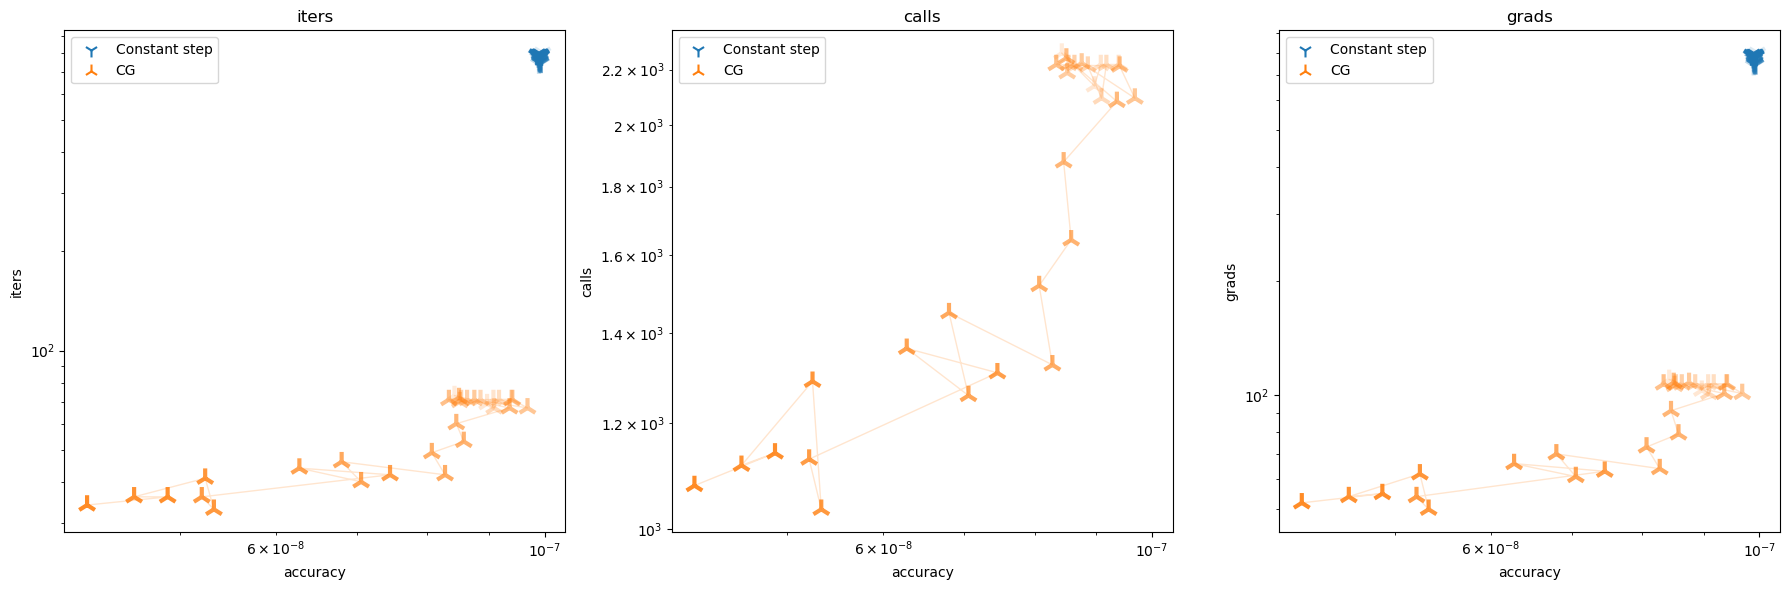

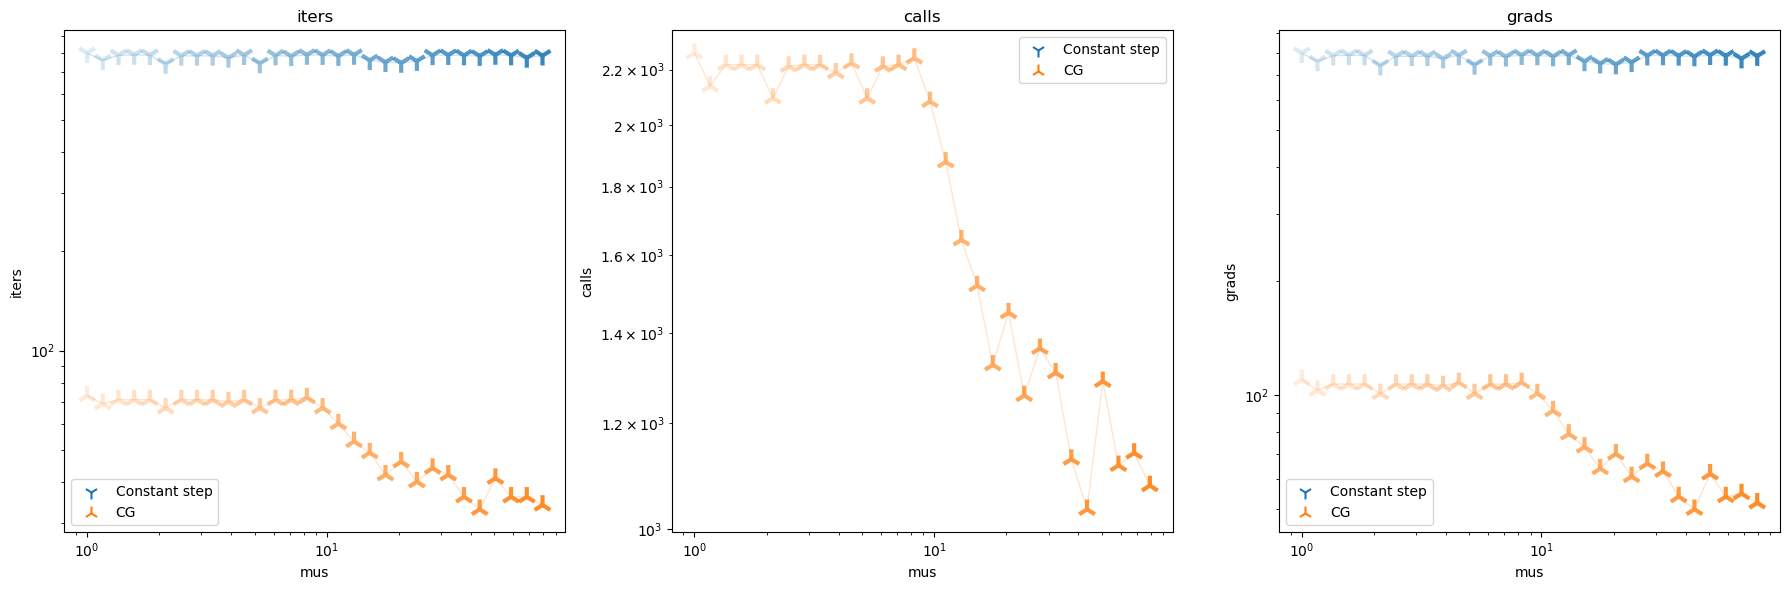

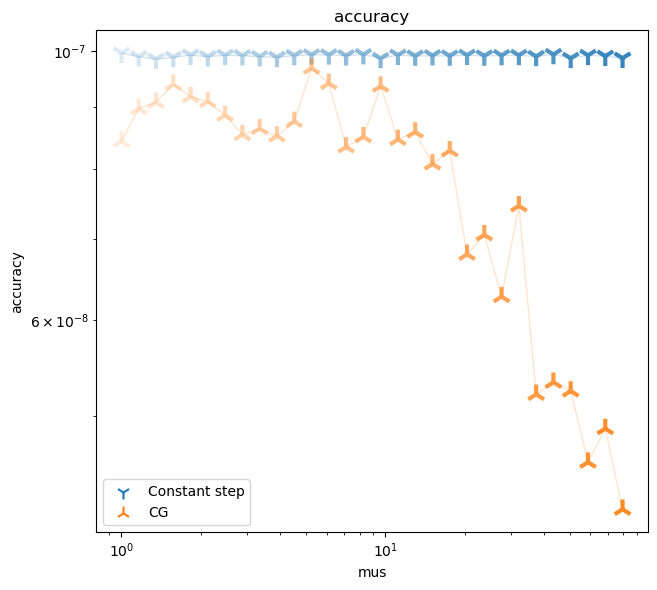

In [ ]:
mus = np.logspace(0, 1.9, 30)
investigate_iter_vs_accuracy(mus, methods, plot_table=True, plot_illustrations=False)
